# ReneWind

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.). 



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 40000 observations in the training set and 10000 in the test set.

The objective is to build various classification models, tune them and find the best one that will help identify failures so that the generator could be repaired before failing/breaking and the overall maintenance cost of the generators can be brought down. 

“1” in the target variables should be considered as “failure” and “0” will represent “No failure”.

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a wind turbine where there is no detection by model. 
- False positives (FP) are detections in a wind turbine where there is no failure. 

So, the maintenance cost associated with the model would be:

**Maintenance cost** = `TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost)`
where,

- `Replacement cost = $40,000`
- `Repair cost = $15,000`
- `Inspection cost = $5,000`

Here the objective is to reduce the maintenance cost so, we want a metric that could reduce the maintenance cost.

- The minimum possible maintenance cost  =  `Actual failures*(Repair cost) = (TP + FN)*(Repair cost)`
- The maintenance cost associated with model = `TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost)`

So, we will try to maximize the ratio of minimum possible maintenance cost and the maintenance cost associated with the model.

The value of this ratio will lie between 0 and 1, the ratio will be 1 only when the maintenance cost associated with the model will be equal to the minimum possible maintenance cost.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing libraries

In [1]:
# import warnings library to hide warning and deprecation messages
import warnings
warnings.filterwarnings("ignore")

# import data handling and numeric processing libraries
import pandas as pd
import numpy as np

# import visualizations and chart libraries
import seaborn as sns
import matplotlib.pyplot as plt

# command to display plots in the notebook
%matplotlib inline

# set styling options
sns.set_style('darkgrid')

# import libraries for variable scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize, PolynomialFeatures, OneHotEncoder

from scipy import stats

# imort vif function
from statsmodels.stats.outliers_influence import variance_inflation_factor

# import library to split data
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# import stats model
import statsmodels.api as sm

# import function to add constant
from statsmodels.tools.tools import add_constant

# import function for missing value imputation
from sklearn.impute import SimpleImputer

# import Logistic Regression function
from sklearn.linear_model import LogisticRegression

# import scoring metrics
from sklearn import metrics

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    precision_recall_curve,
    roc_curve,
    make_scorer,
    classification_report,
)

# import libraries to build decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# import library tune different models
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# libraries to import different ensemble classifiers

# bagging classifiers
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

# boosting classifiers
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from xgboost import plot_importance

# pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# automatic python code structure
%load_ext nb_black

# library to over sample data
from imblearn.over_sampling import SMOTE

# library to under sample data
from imblearn.under_sampling import RandomUnderSampler 

# library for creating Pipeline
from sklearn.pipeline import Pipeline

<IPython.core.display.Javascript object>

## Loading Data

In [2]:
# import train and test data
train = pd.read_csv('Train.csv')

test = pd.read_csv('Test.csv')

<IPython.core.display.Javascript object>

## Data Overview

In [3]:
# find number of observations and features for train data
train.shape

(40000, 41)

<IPython.core.display.Javascript object>

In [4]:
# find number of observations and features for test data
test.shape

(10000, 41)

<IPython.core.display.Javascript object>

In [5]:
# check train data load
train.sample(8)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
9777,-4.961,0.306,1.989,-1.137,3.955,0.016,-5.256,-2.683,1.127,-0.674,-4.370,-1.571,7.141,-0.374,-12.886,-6.887,-3.528,7.442,-4.975,-3.405,-8.386,2.903,3.577,5.557,-4.022,7.573,-5.986,-4.790,-2.250,2.841,3.501,11.962,8.098,-8.821,4.607,3.795,-0.559,-2.773,1.669,-2.464,0
26356,-4.579,3.886,2.345,2.458,2.774,-0.704,-1.823,-2.428,0.562,-1.358,-2.214,1.117,3.024,-2.643,-6.657,-4.251,-0.367,1.988,0.773,-2.381,-4.224,0.146,0.178,4.053,-3.241,7.214,-5.788,-1.622,-0.433,1.100,-0.137,4.634,4.236,-2.410,2.196,-0.200,-0.562,2.496,1.553,-2.781,0
6815,5.024,4.425,5.813,-2.601,-0.423,2.639,0.217,-8.865,2.070,2.032,0.932,-2.771,1.525,-3.264,-1.510,-9.825,-6.619,0.689,1.890,-7.808,-6.926,1.254,-7.344,-0.806,1.211,7.176,6.580,-2.335,-1.850,-4.189,1.964,-5.932,2.517,-1.600,2.900,0.937,-3.274,7.439,2.280,-1.496,0
25768,-4.943,-7.488,0.593,0.480,-2.576,-2.488,-3.442,4.078,-0.651,0.282,-1.906,1.829,3.362,2.370,-4.171,1.544,1.559,1.854,0.492,8.945,-1.195,-0.383,1.004,-2.400,-0.093,-6.203,-2.500,-0.040,1.293,4.811,-2.153,1.289,-0.641,2.359,2.565,3.319,2.818,-8.438,0.981,-1.923,0
25682,-0.368,4.682,-0.352,-1.312,1.791,-0.091,1.192,0.780,0.036,-4.724,0.392,5.045,1.003,-2.999,-1.406,-0.124,2.542,1.673,-1.753,-2.281,-1.149,0.682,2.997,-0.026,-1.215,4.320,-3.909,-1.454,2.258,1.073,-2.082,-2.555,0.310,-2.948,-1.754,-1.680,2.257,1.794,-0.045,3.682,0
4189,1.072,2.870,-1.179,0.534,1.678,2.060,-0.321,-3.680,2.044,-1.087,-0.514,-3.550,-1.455,-1.248,-1.048,-4.308,0.729,1.993,-1.980,-2.614,-0.929,1.332,-0.121,1.844,-0.143,2.410,-0.920,0.330,-0.592,-1.172,-1.145,0.213,1.644,-3.067,-1.087,-2.446,-0.728,3.625,-0.629,0.678,0
6221,-3.104,-1.726,-4.664,2.822,0.539,0.932,-2.420,-1.286,4.081,-2.767,-1.925,-4.669,0.680,1.325,-4.209,-2.993,4.469,3.261,-3.913,5.850,0.993,1.181,2.620,-1.562,-0.180,-3.263,-3.827,1.810,-0.377,1.037,-6.841,0.032,-0.959,-1.264,-3.693,-3.123,2.401,-2.097,-0.564,-0.563,1
18898,-2.023,1.630,3.696,7.980,-1.762,-1.499,-3.715,-4.326,3.385,-0.809,-2.799,-2.663,0.883,-3.424,-6.752,-10.800,2.895,0.360,7.144,4.096,-8.715,1.745,-3.548,4.076,-1.359,2.436,-6.156,1.723,0.289,3.920,-5.909,1.878,3.071,1.036,8.170,-5.602,-1.825,1.802,-0.553,-7.157,0


<IPython.core.display.Javascript object>

In [6]:
# check test data load
test.sample(8)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
6861,2.043,2.953,2.497,1.189,-0.419,0.428,-0.100,-4.083,1.897,0.421,0.615,-1.599,1.882,-1.691,-2.119,-5.069,-2.871,-1.016,2.243,-3.079,-4.321,0.671,-2.823,0.020,-0.362,4.435,1.490,-0.932,-1.012,-1.134,-0.398,-0.975,1.580,-0.461,2.576,-1.782,-2.172,3.167,0.484,-2.798,0
499,2.866,4.101,3.000,4.296,-1.025,0.784,-1.868,-7.066,4.906,-0.789,-0.386,-5.085,2.129,-2.967,-5.241,-11.148,-1.402,-0.096,3.314,-1.739,-8.406,2.229,-3.984,0.998,-0.421,5.524,-0.653,-0.326,-1.029,0.123,-3.607,-0.698,3.055,-1.906,5.299,-5.533,-3.039,3.817,-0.572,-4.951,0
6679,3.137,-2.070,13.289,-4.297,-2.642,-3.767,-1.464,-1.064,-1.735,4.438,-5.858,4.208,4.690,-0.665,-1.596,-5.867,-5.039,0.356,4.431,0.248,-9.486,0.008,-8.197,-2.039,4.362,3.805,7.798,-4.107,-4.938,-5.371,8.688,-5.290,-3.878,2.384,6.503,11.920,-1.250,-4.303,4.724,-1.485,0
1371,-0.723,-0.293,1.303,2.392,-0.656,-1.707,-1.248,0.480,0.651,-0.196,-1.736,0.486,1.582,-0.227,-2.669,-2.117,0.985,-0.146,2.118,2.190,-3.159,0.814,0.473,1.319,-0.438,0.517,-2.106,0.043,-0.820,1.232,-0.922,2.299,-0.070,0.340,2.979,-0.631,-0.312,-1.847,-0.198,-2.506,0
9203,-1.345,-4.233,-0.420,-4.105,-2.197,-0.281,-1.910,-0.033,1.176,-1.358,-0.616,3.753,5.975,0.775,-5.890,-3.383,-0.892,4.711,-2.013,3.916,-4.332,2.711,2.602,-4.838,0.414,-3.056,1.633,-1.682,-0.178,2.013,-4.915,-4.796,-2.009,-0.140,-0.256,3.315,3.945,-3.730,2.479,0.234,0
7196,-3.593,0.522,0.702,-1.229,1.510,1.262,-2.294,-3.509,0.478,-0.259,-0.665,0.202,3.234,-1.455,-6.603,-4.985,-2.397,4.405,-1.263,-2.338,-3.981,1.337,0.344,1.867,-2.409,3.455,-2.274,-1.756,0.104,1.848,-1.123,2.109,4.527,-2.802,1.460,1.394,0.417,2.333,2.088,-1.511,0
3491,7.773,6.761,14.142,2.459,-4.230,-0.572,-0.953,-12.409,5.006,2.400,-1.732,-2.189,4.308,-6.433,-4.373,-19.137,-6.442,-2.526,10.775,-4.593,-16.480,1.817,-14.477,-2.078,3.109,10.967,7.702,-2.298,-3.655,-5.410,-0.624,-11.575,0.001,2.517,10.200,-0.715,-5.362,7.849,3.388,-7.483,0
1644,3.323,-3.015,11.273,-4.472,-4.222,-1.922,-1.819,-2.676,-0.121,3.461,-1.811,2.226,5.927,-0.724,-2.664,-6.188,-6.805,0.054,3.823,0.541,-9.280,-0.299,-9.002,-5.654,3.489,2.345,8.336,-4.215,-1.777,-2.368,4.849,-7.948,-1.375,2.255,6.572,8.543,-0.939,-3.767,4.167,-2.023,0


<IPython.core.display.Javascript object>

In [7]:
# basic info of the train data set
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      39954 non-null  float64
 1   V2      39961 non-null  float64
 2   V3      40000 non-null  float64
 3   V4      40000 non-null  float64
 4   V5      40000 non-null  float64
 5   V6      40000 non-null  float64
 6   V7      40000 non-null  float64
 7   V8      40000 non-null  float64
 8   V9      40000 non-null  float64
 9   V10     40000 non-null  float64
 10  V11     40000 non-null  float64
 11  V12     40000 non-null  float64
 12  V13     40000 non-null  float64
 13  V14     40000 non-null  float64
 14  V15     40000 non-null  float64
 15  V16     40000 non-null  float64
 16  V17     40000 non-null  float64
 17  V18     40000 non-null  float64
 18  V19     40000 non-null  float64
 19  V20     40000 non-null  float64
 20  V21     40000 non-null  float64
 21  V22     40000 non-null  float64
 22

<IPython.core.display.Javascript object>

In [8]:
# basic info of the test data set
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      9989 non-null   float64
 1   V2      9993 non-null   float64
 2   V3      10000 non-null  float64
 3   V4      10000 non-null  float64
 4   V5      10000 non-null  float64
 5   V6      10000 non-null  float64
 6   V7      10000 non-null  float64
 7   V8      10000 non-null  float64
 8   V9      10000 non-null  float64
 9   V10     10000 non-null  float64
 10  V11     10000 non-null  float64
 11  V12     10000 non-null  float64
 12  V13     10000 non-null  float64
 13  V14     10000 non-null  float64
 14  V15     10000 non-null  float64
 15  V16     10000 non-null  float64
 16  V17     10000 non-null  float64
 17  V18     10000 non-null  float64
 18  V19     10000 non-null  float64
 19  V20     10000 non-null  float64
 20  V21     10000 non-null  float64
 21  V22     10000 non-null  float64
 22 

<IPython.core.display.Javascript object>

In [9]:
# Let's check duplicate values train data
train[train.duplicated()].count()

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
Target    0
dtype: int64

<IPython.core.display.Javascript object>

In [10]:
# Let's check duplicate values test data
test[test.duplicated()].count()

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
Target    0
dtype: int64

<IPython.core.display.Javascript object>

In [11]:
# Check missing values train data
train.isnull().sum()

V1        46
V2        39
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

<IPython.core.display.Javascript object>

In [12]:
# Check missing values train data
test.isnull().sum()

V1        11
V2         7
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

<IPython.core.display.Javascript object>

In [13]:
# Let's summarize the train data
train.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,39954.000,-0.288,3.449,-13.502,-2.751,-0.774,1.837,17.437
V2,39961.000,0.443,3.139,-13.212,-1.638,0.464,2.538,13.089
V3,40000.000,2.506,3.406,-11.469,0.203,2.265,4.585,18.366
V4,40000.000,-0.066,3.437,-16.015,-2.350,-0.124,2.149,13.280
V5,40000.000,-0.045,2.107,-8.613,-1.507,-0.097,1.346,9.403
V6,40000.000,-1.001,2.037,-10.227,-2.363,-1.007,0.374,7.065
V7,40000.000,-0.893,1.757,-8.206,-2.037,-0.935,0.207,8.006
V8,40000.000,-0.563,3.299,-15.658,-2.660,-0.384,1.714,11.679
V9,40000.000,-0.008,2.162,-8.596,-1.494,-0.052,1.426,8.507
V10,40000.000,-0.002,2.183,-11.001,-1.391,0.106,1.486,8.108


<IPython.core.display.Javascript object>

In [14]:
# Let's summarize the test data
test.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,9989.000,-0.260,3.440,-12.382,-2.700,-0.719,1.861,13.504
V2,9993.000,0.417,3.160,-11.625,-1.701,0.456,2.526,14.079
V3,10000.000,2.555,3.395,-12.941,0.238,2.283,4.656,15.409
V4,10000.000,-0.054,3.462,-14.682,-2.371,-0.169,2.144,12.896
V5,10000.000,-0.085,2.102,-7.712,-1.593,-0.144,1.324,7.673
V6,10000.000,-1.014,2.039,-8.949,-2.377,-1.015,0.354,6.273
V7,10000.000,-0.908,1.737,-8.124,-2.035,-0.938,0.189,7.616
V8,10000.000,-0.599,3.343,-12.710,-2.684,-0.387,1.698,10.792
V9,10000.000,0.026,2.180,-7.570,-1.490,-0.086,1.466,8.851
V10,10000.000,0.019,2.169,-8.291,-1.362,0.150,1.537,7.691


<IPython.core.display.Javascript object>

### Observations 
- The data contains 40 features and 1 target column
- Train data contains 40000 observations and test data contains 10000 observations
- All the columns have float data type
- The target variable has value 0 or 1
- There are no duplicate values in the data set
- Column V1 and V2 have missing values
- The data for all the columns ranges between negative and positive values (~ -23 to 24)

## EDA and insights

In [15]:
# function to plot histogram and boxplot for features
def Hist_Bar_Plt(variable,title):
    """This function plots histogram and bar plot 
       for the input variable. The histogram plots 
       shows mean and median lines."""

    fig, ax = plt.subplots(nrows=2,figsize=(15,12))

    fig.suptitle(f'Histogram and Boxplot for {title}')
    
    mean = variable.mean()
    median = variable.median()
    sns.histplot(x=variable, ax=ax[0], kde=True)
    ax[0].axvline(mean, color='r', linestyle='-', label="Mean")
    ax[0].axvline(median, color='b', linestyle='-', label="Median")
    ax[0].legend()
    
    sns.boxplot(ax=ax[1],x=variable,showmeans=True,palette="Set2")
    fig.show()

<IPython.core.display.Javascript object>

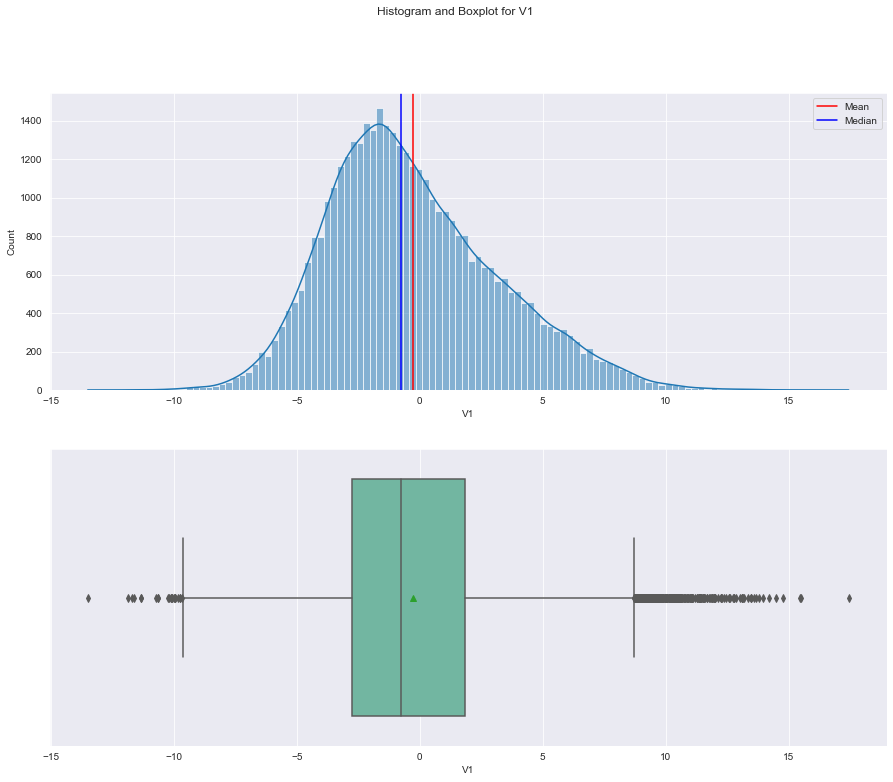

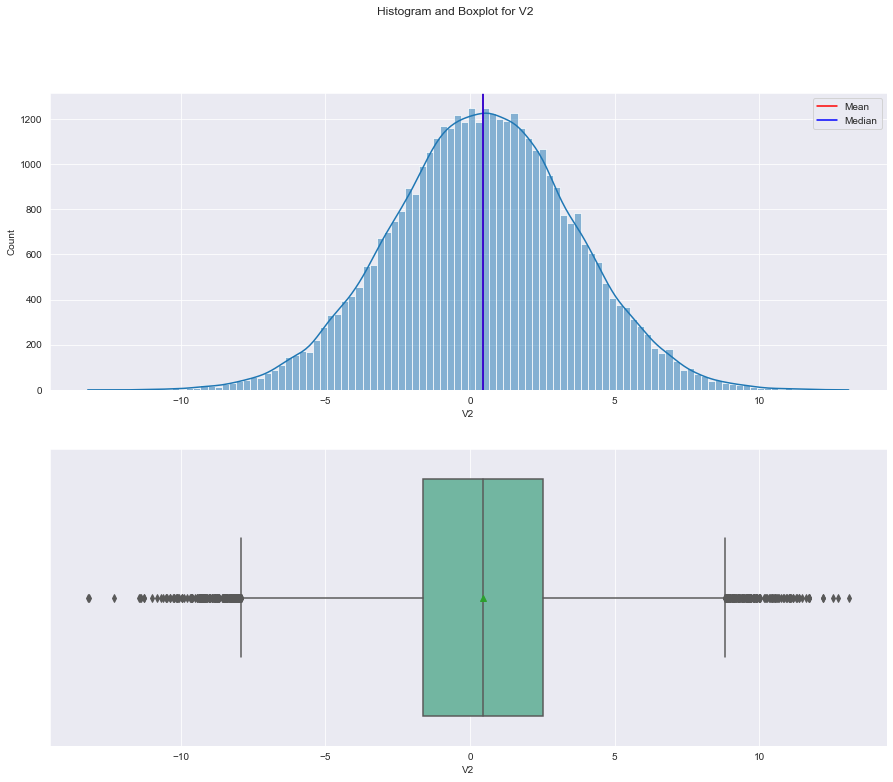

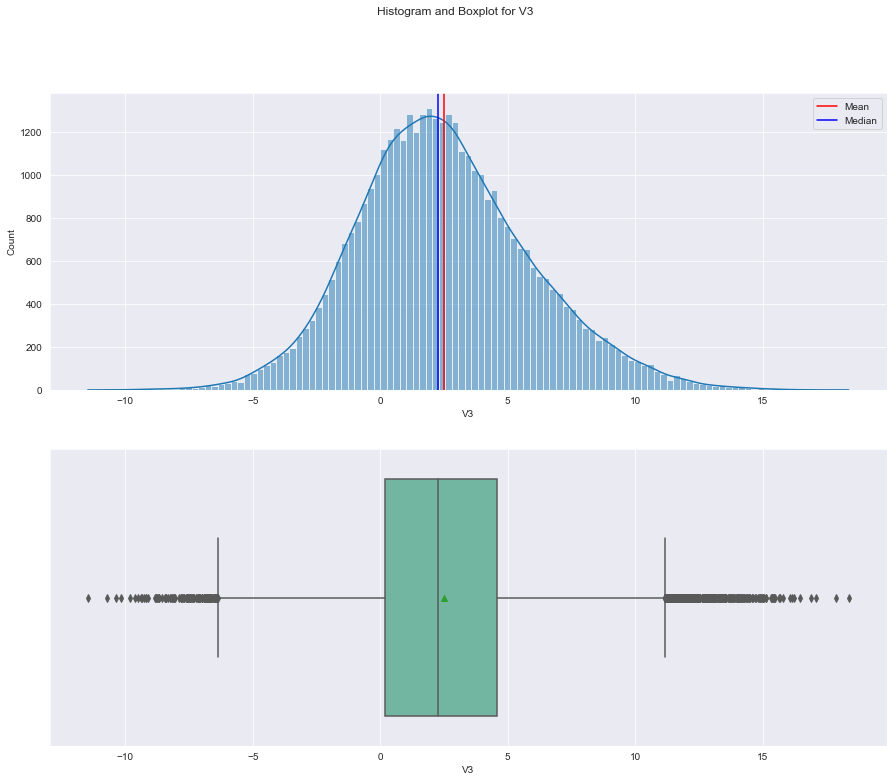

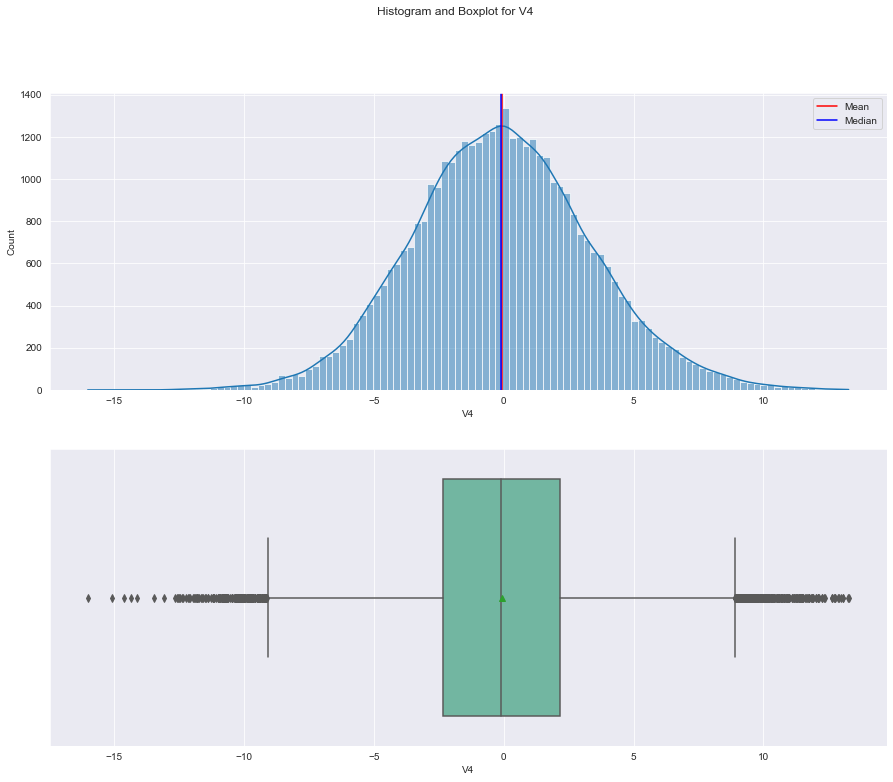

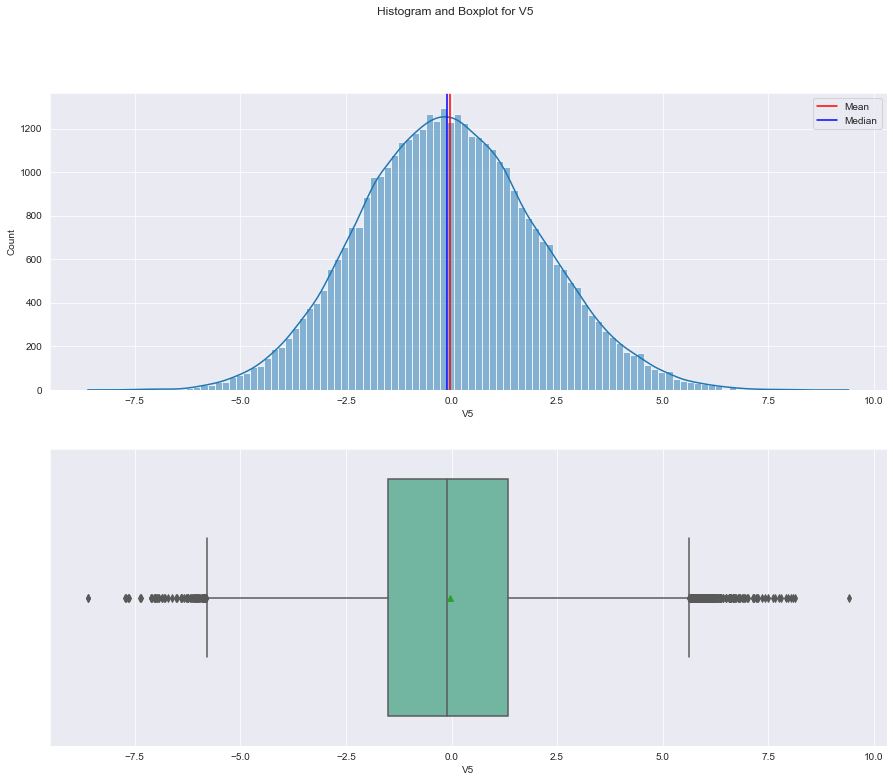

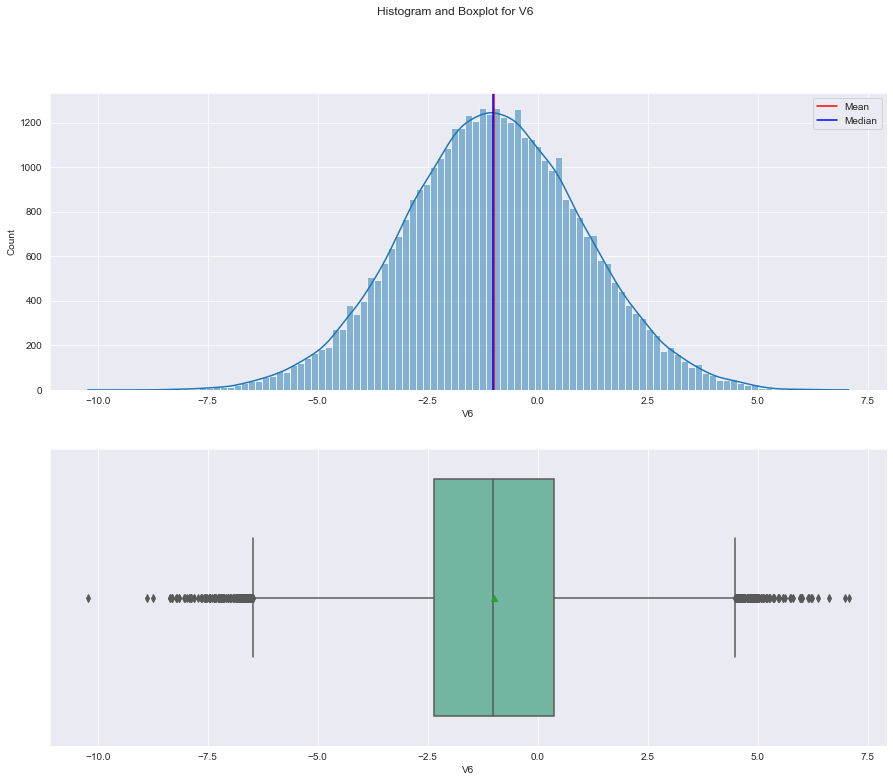

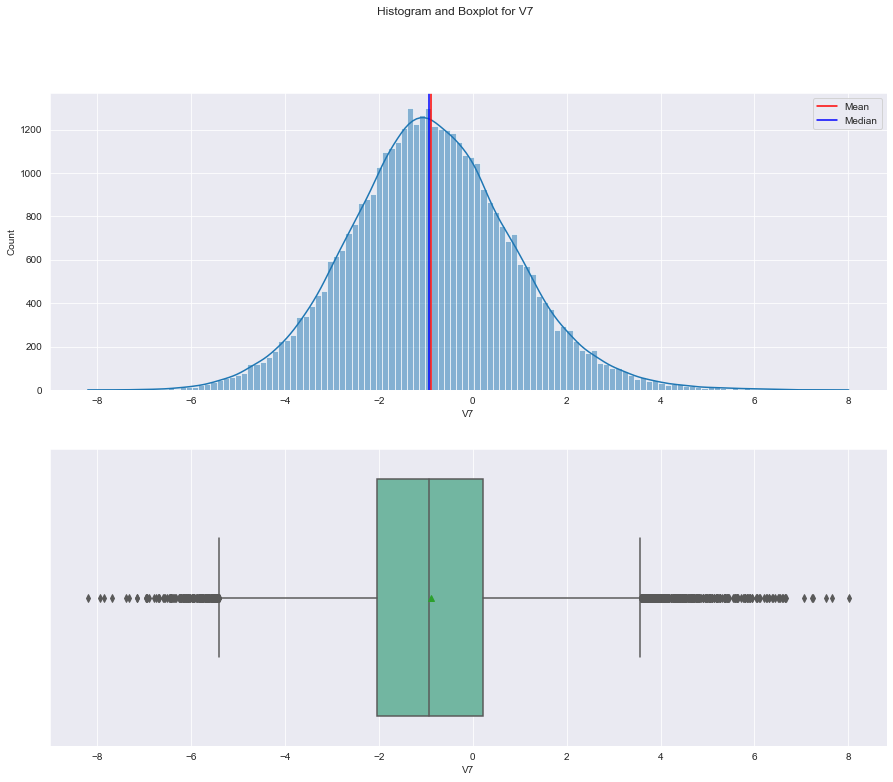

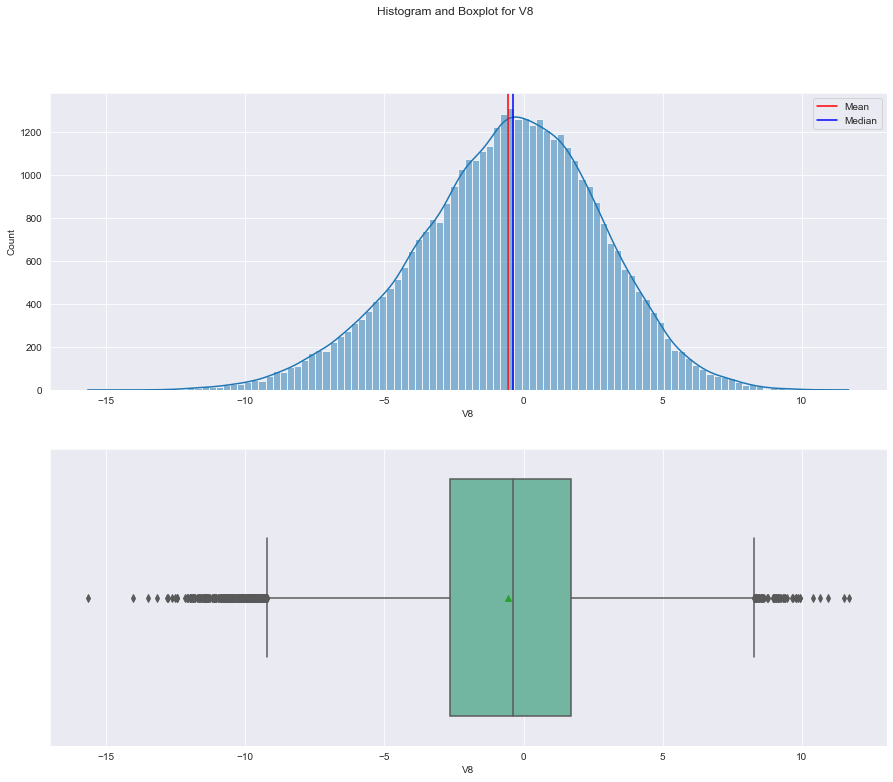

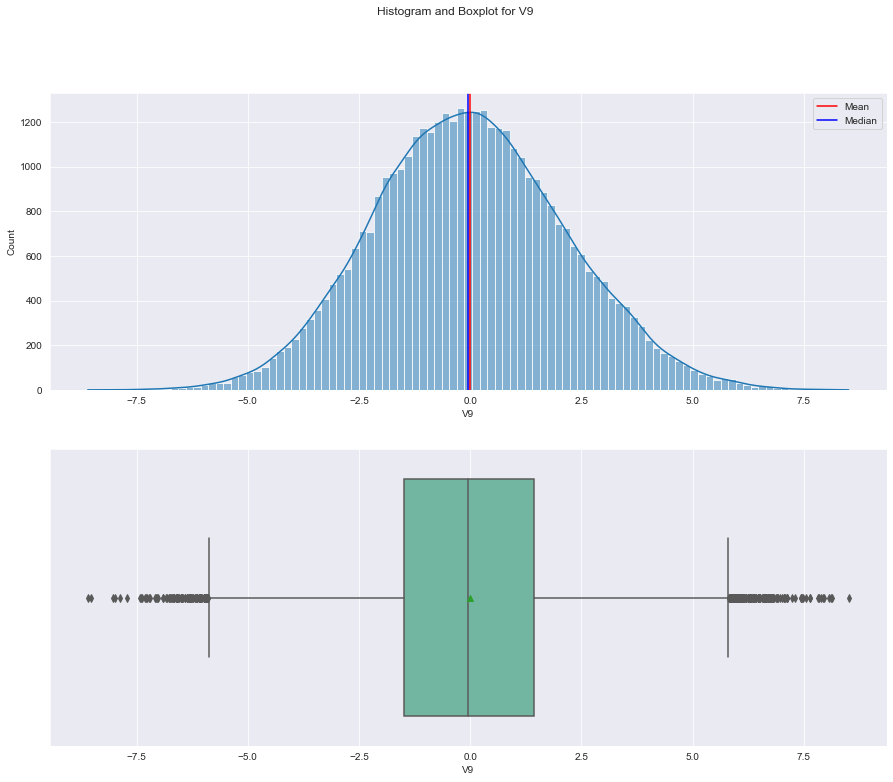

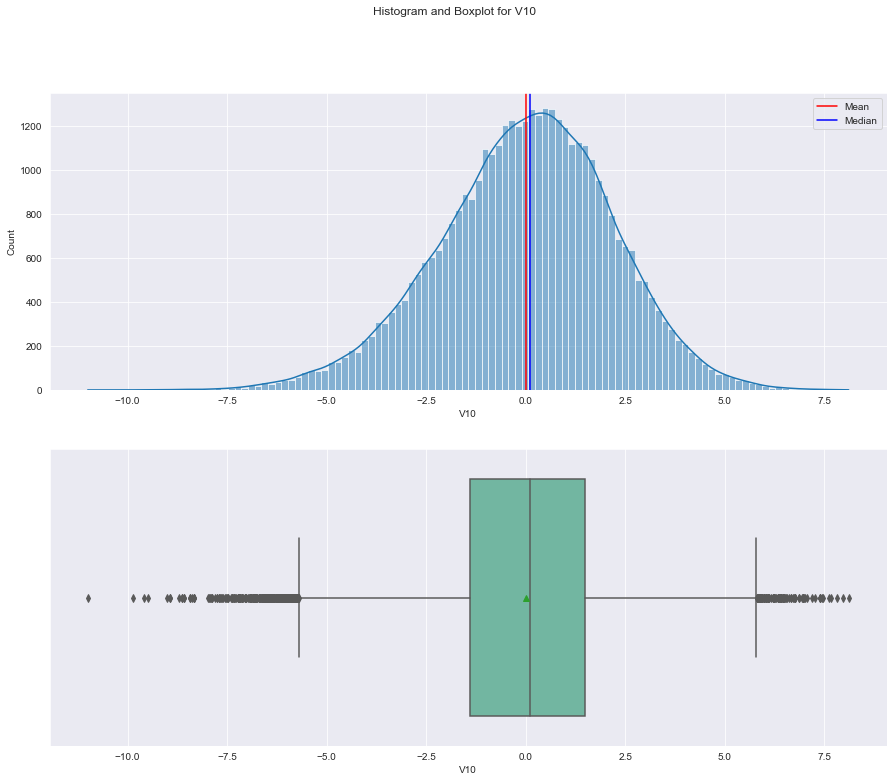

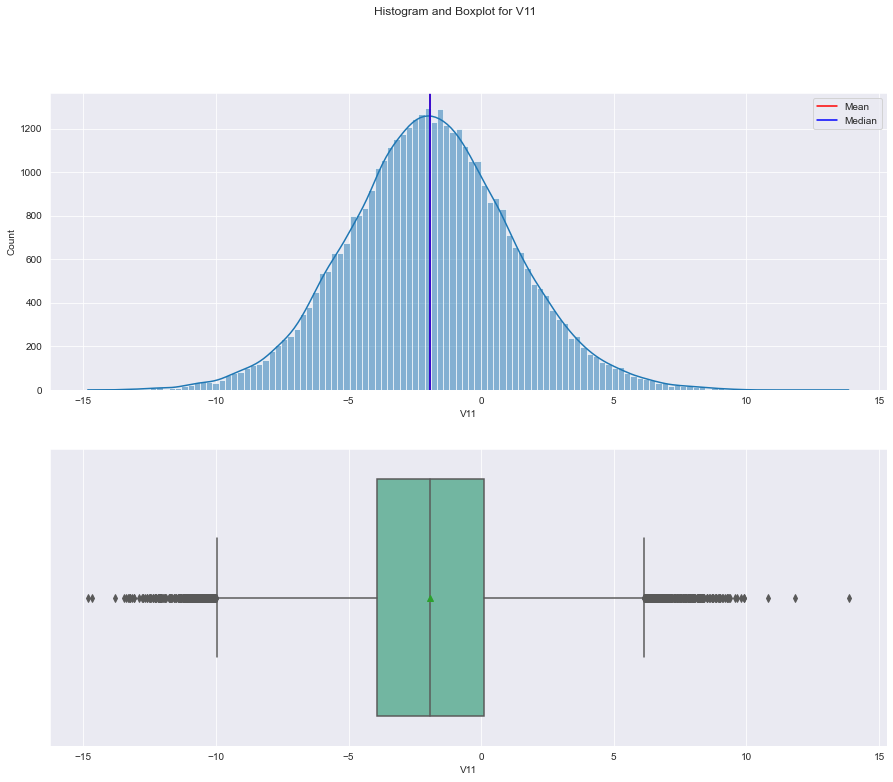

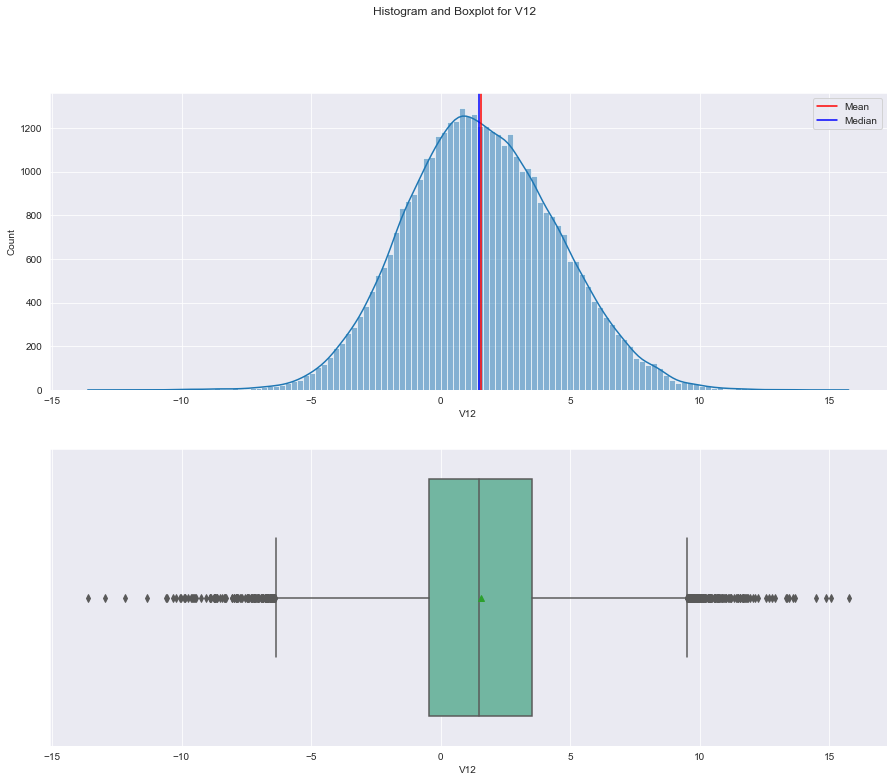

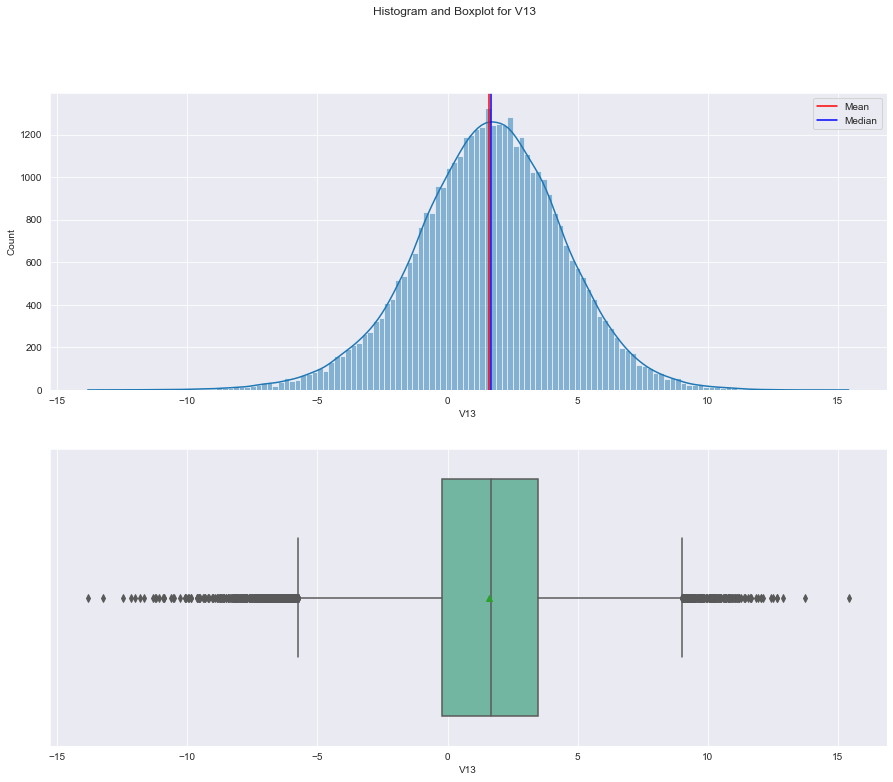

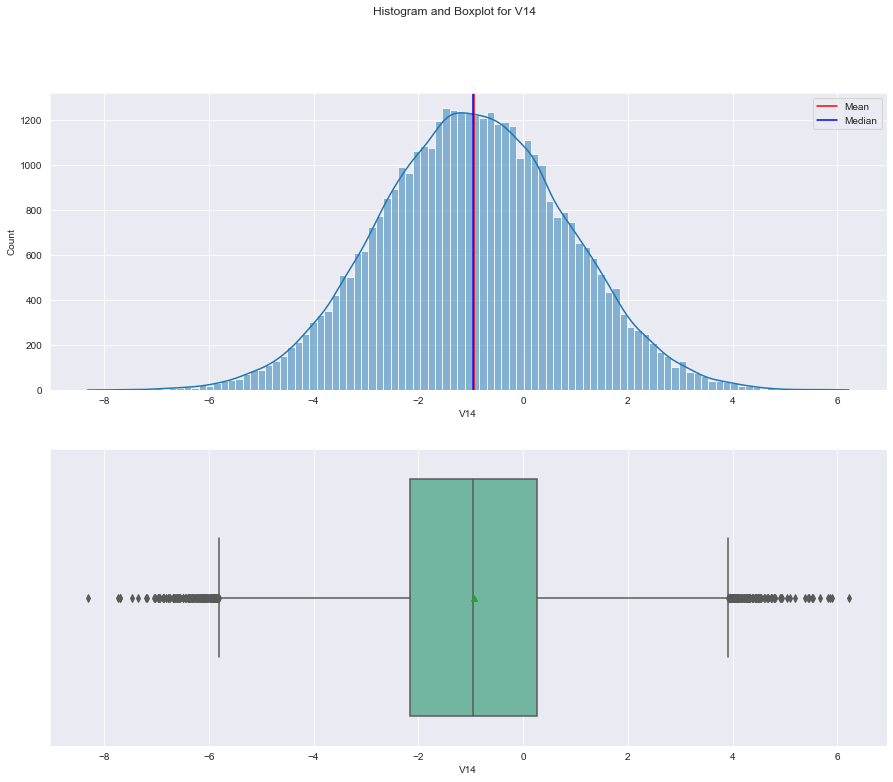

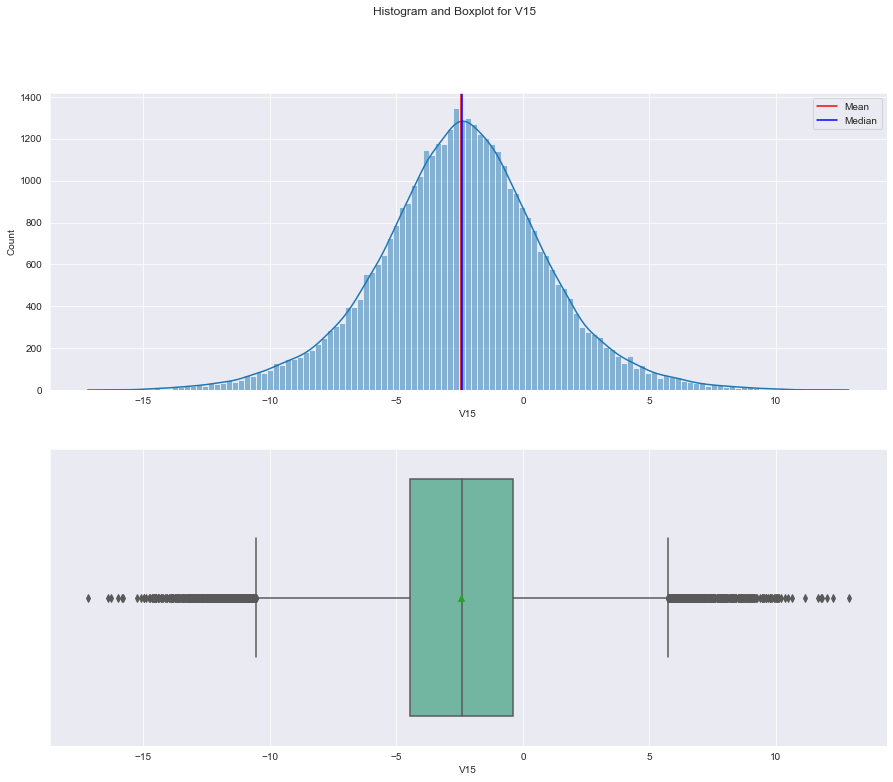

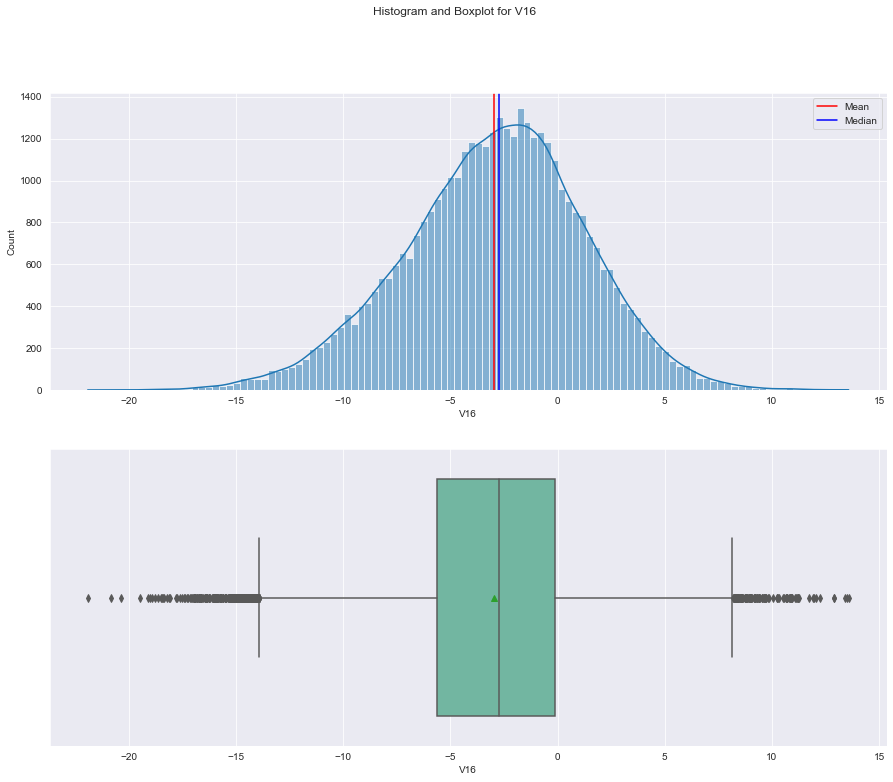

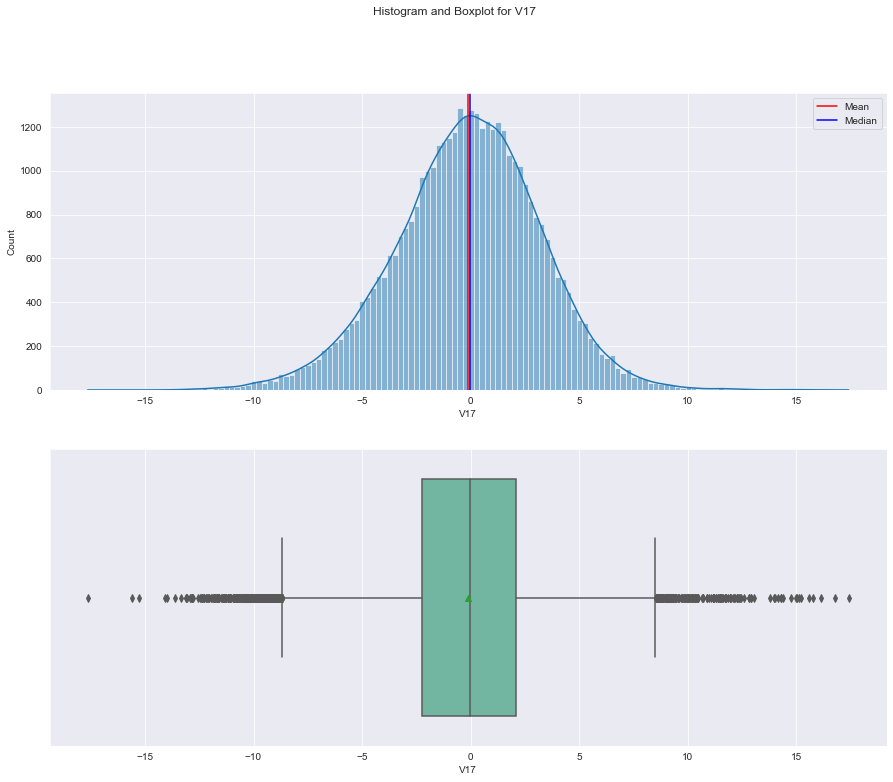

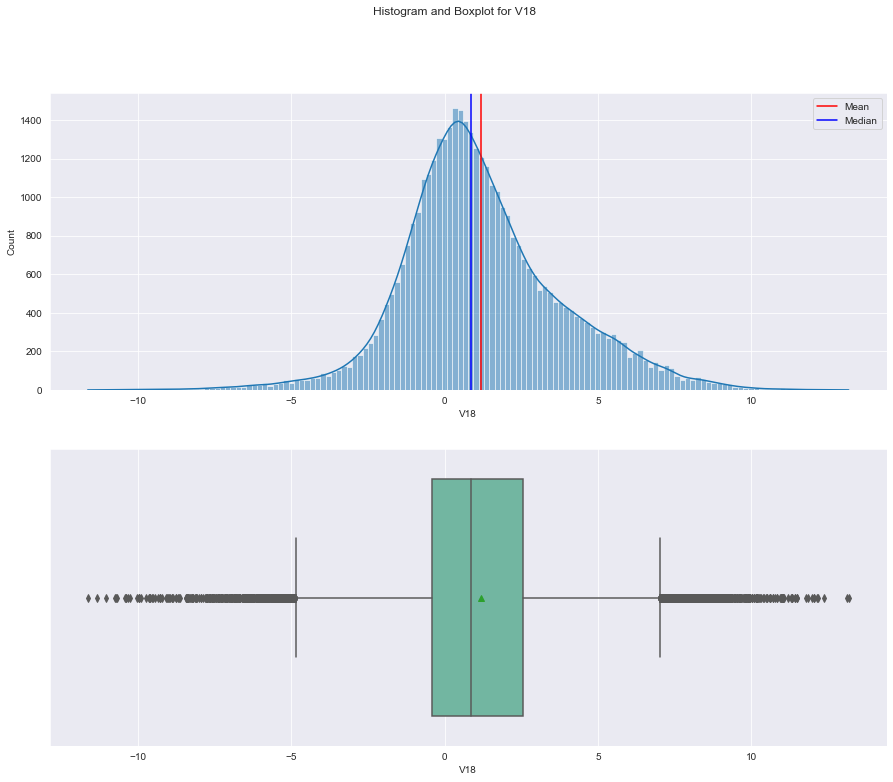

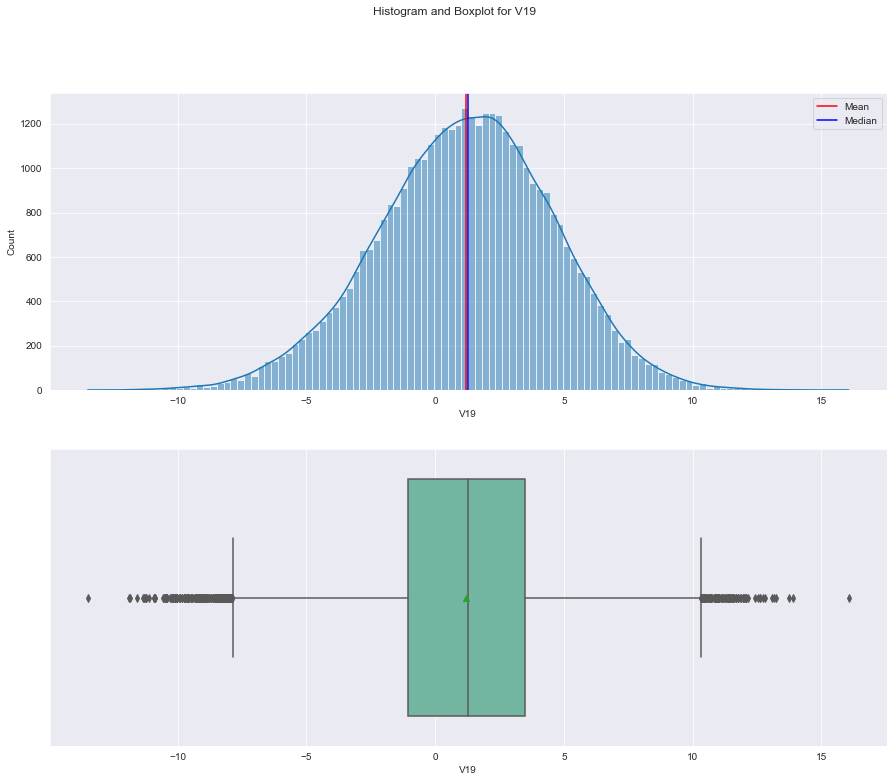

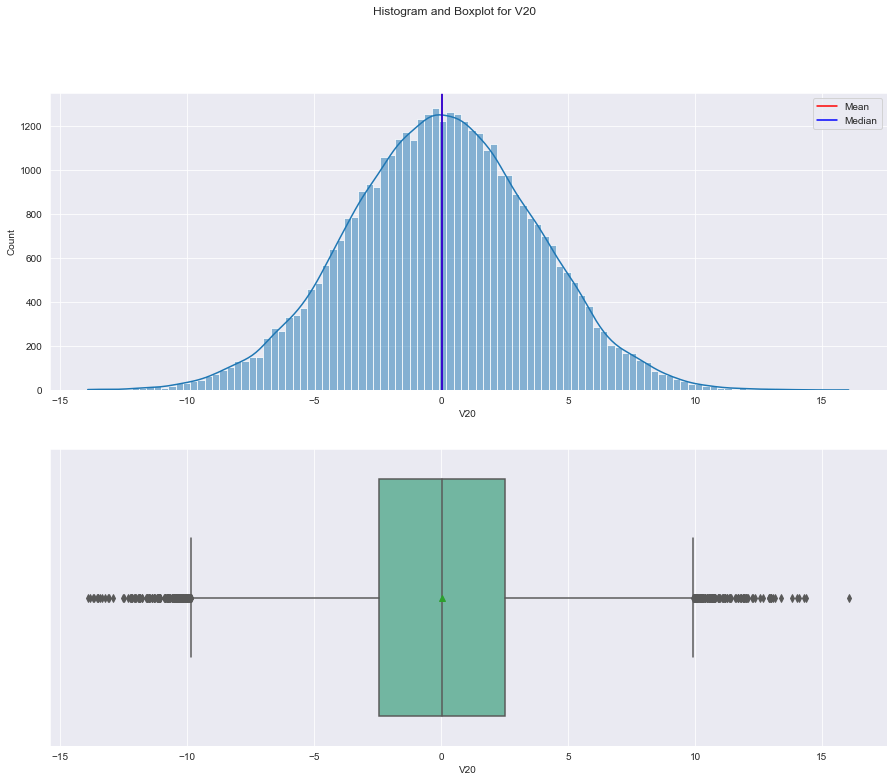

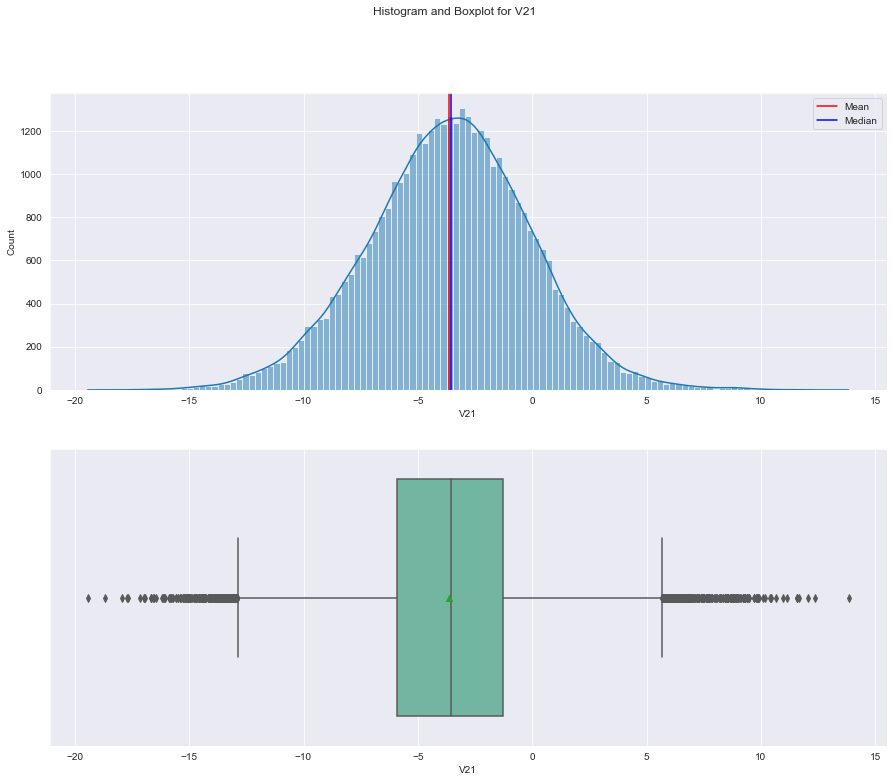

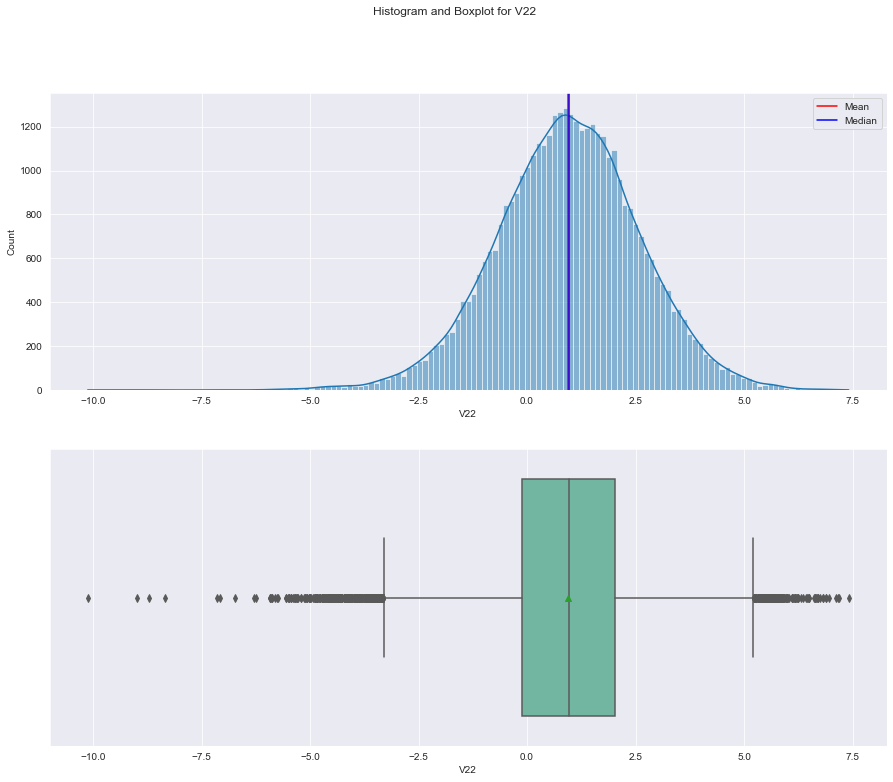

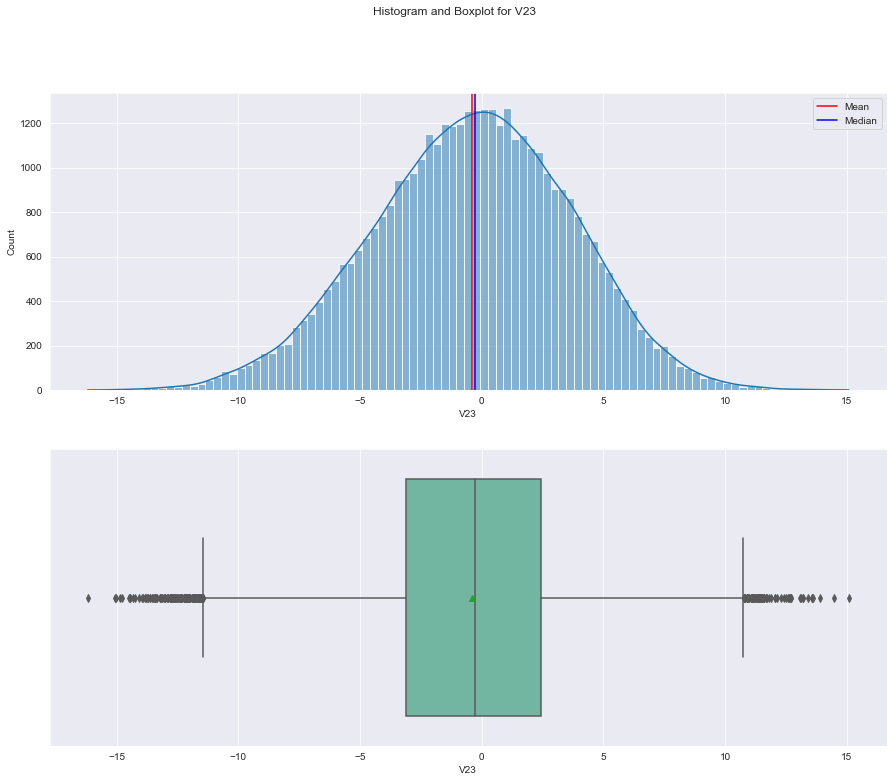

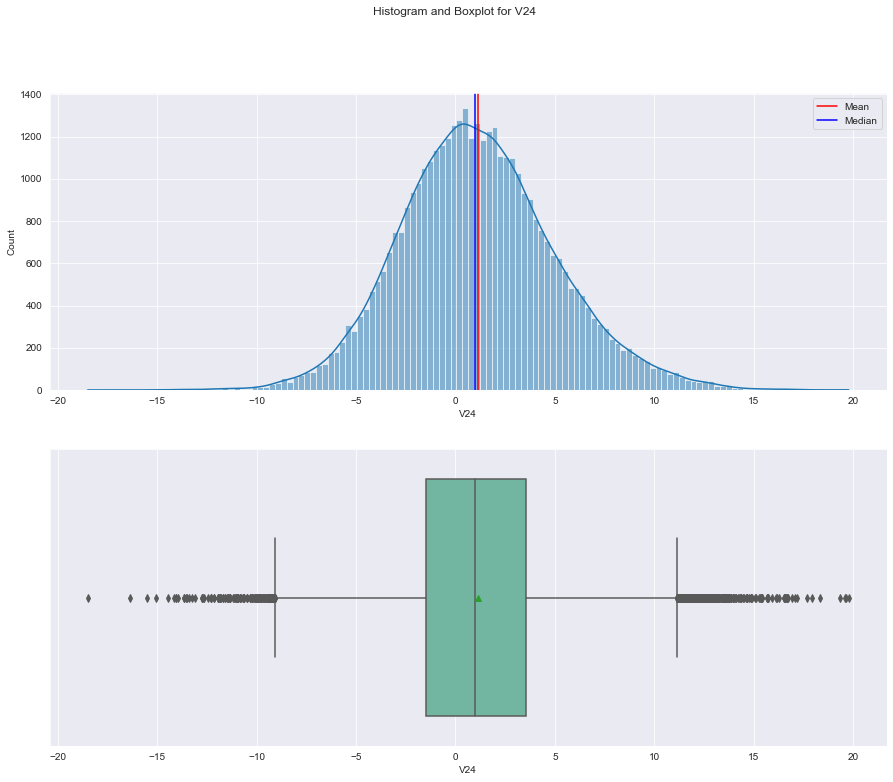

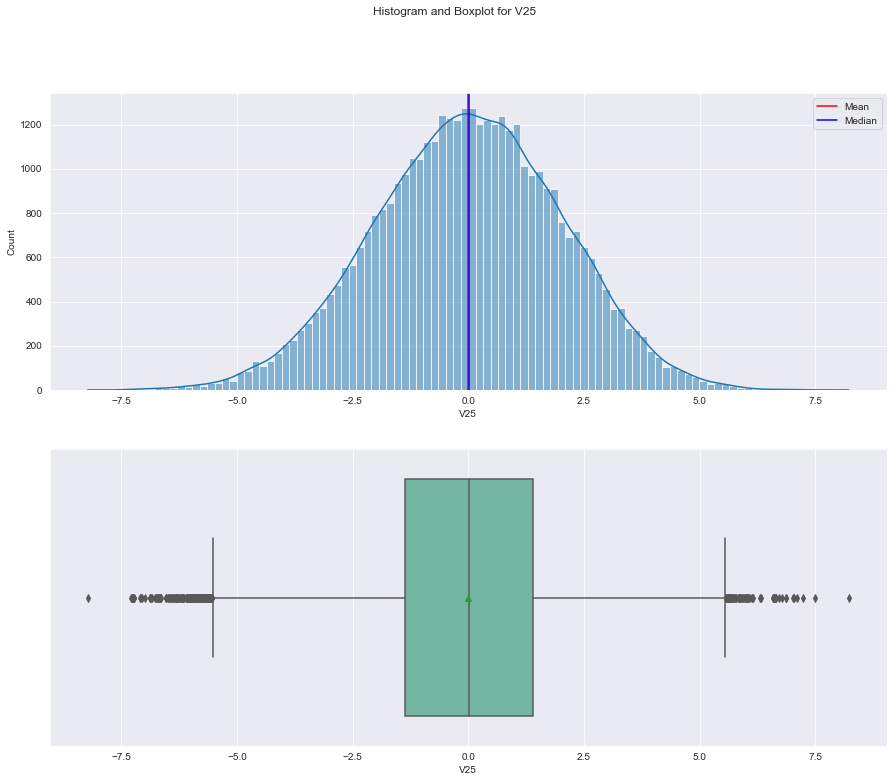

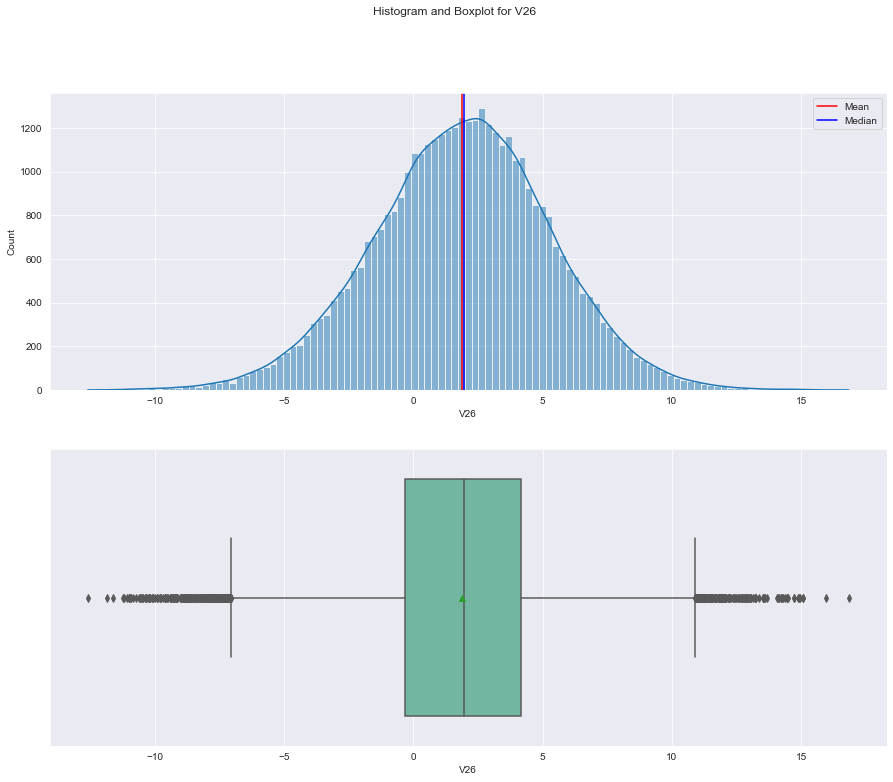

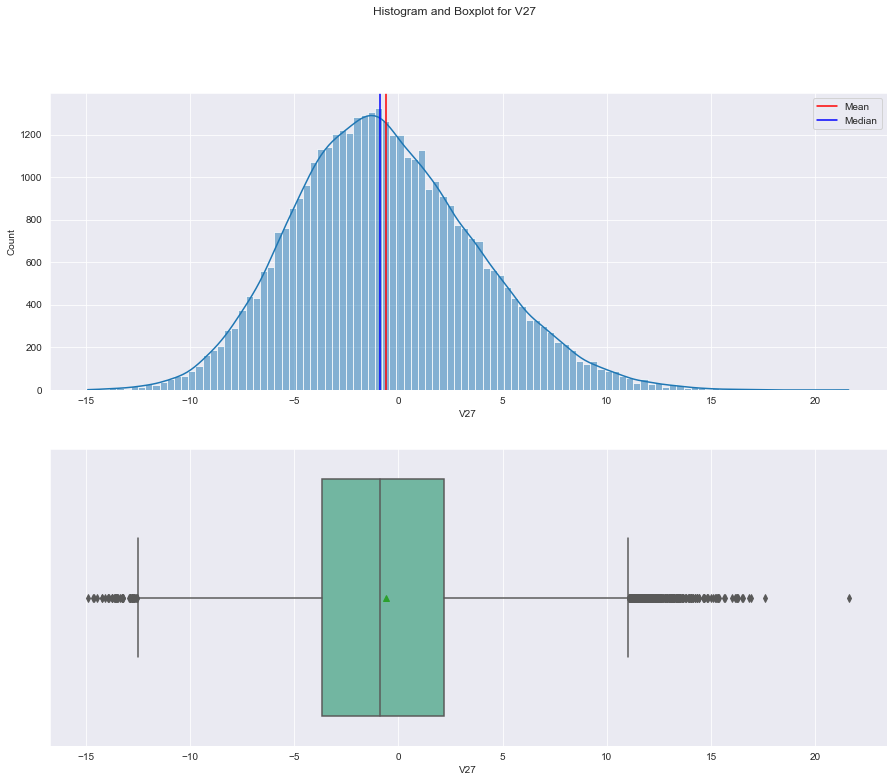

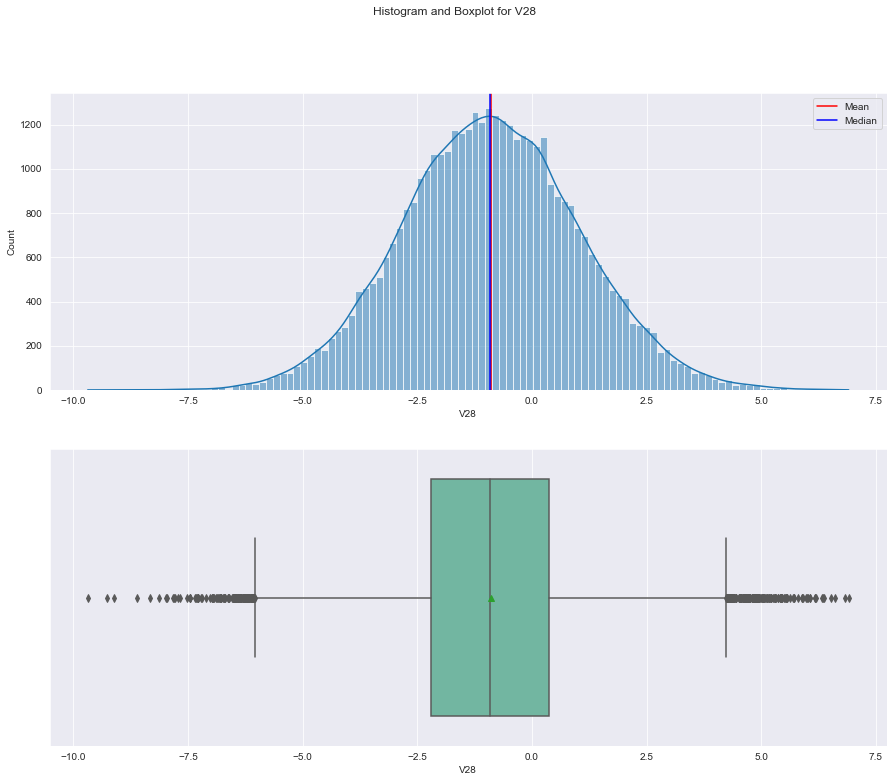

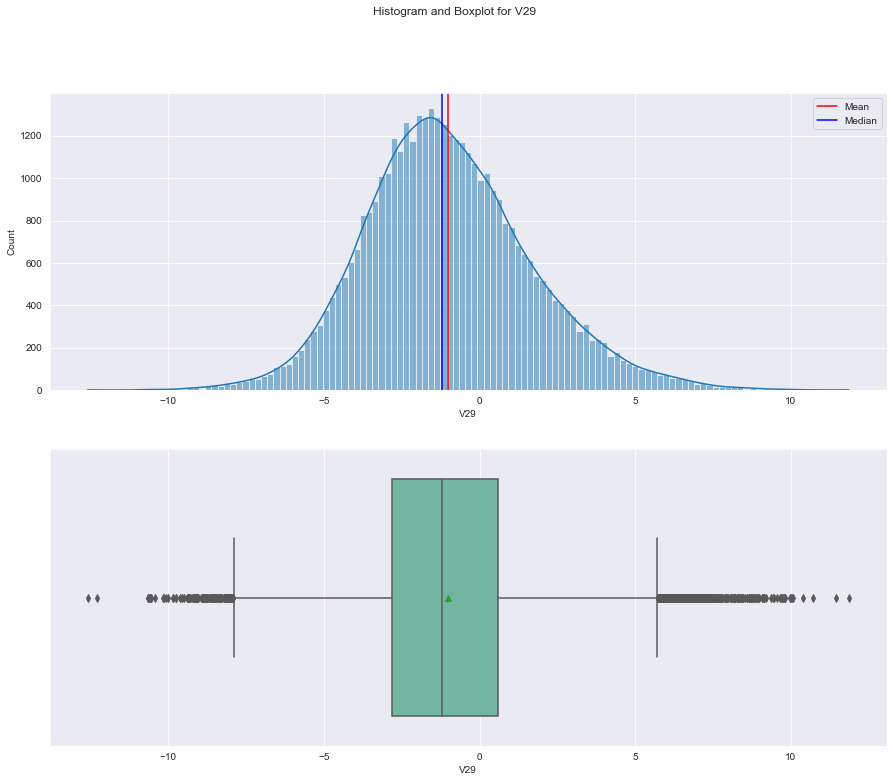

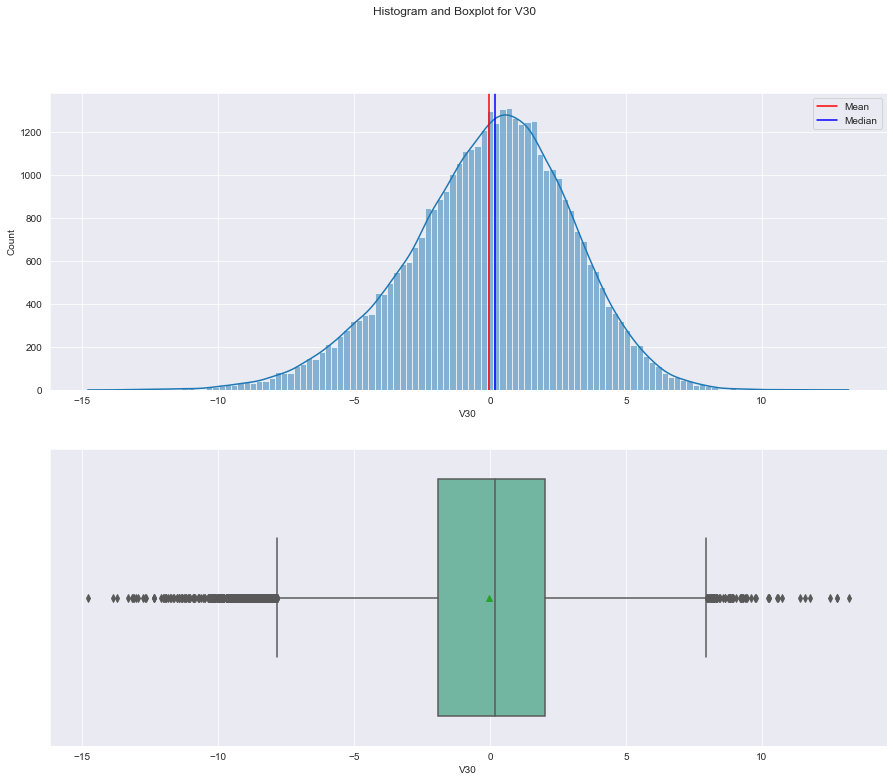

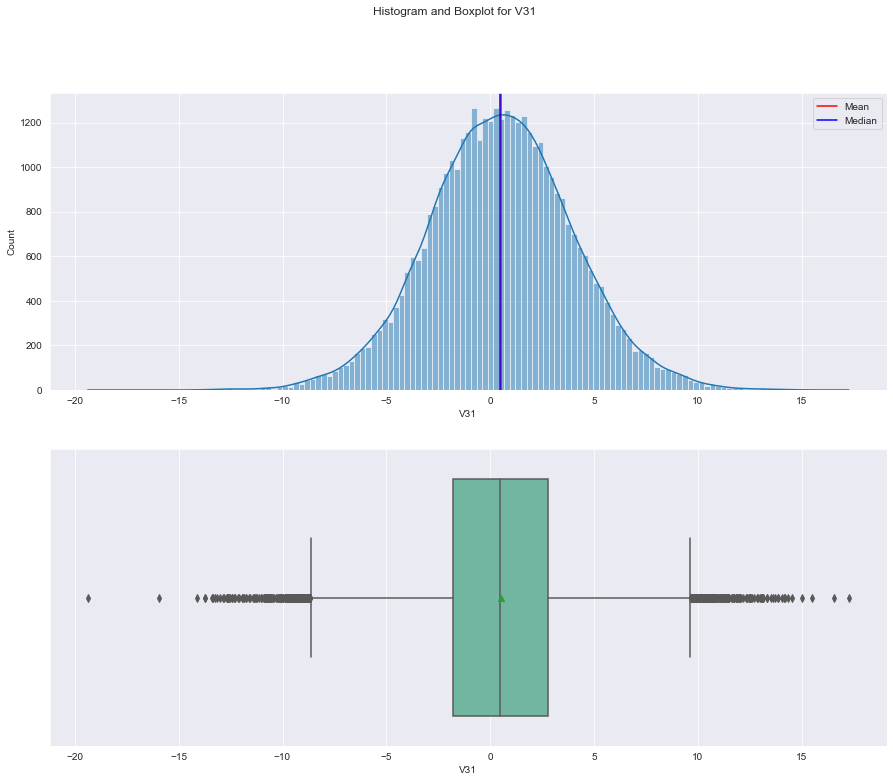

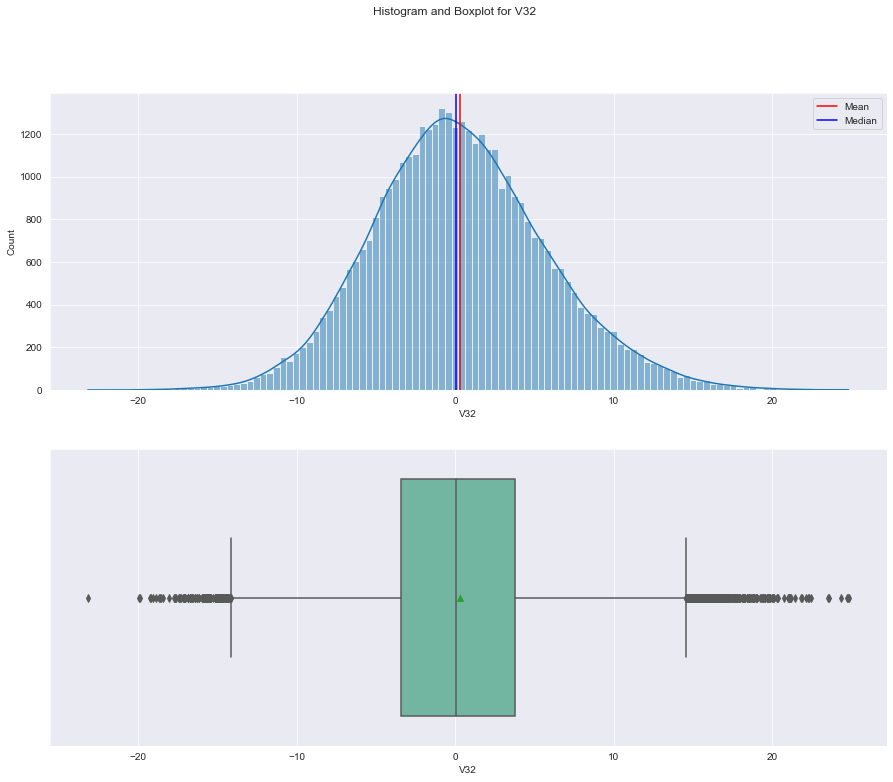

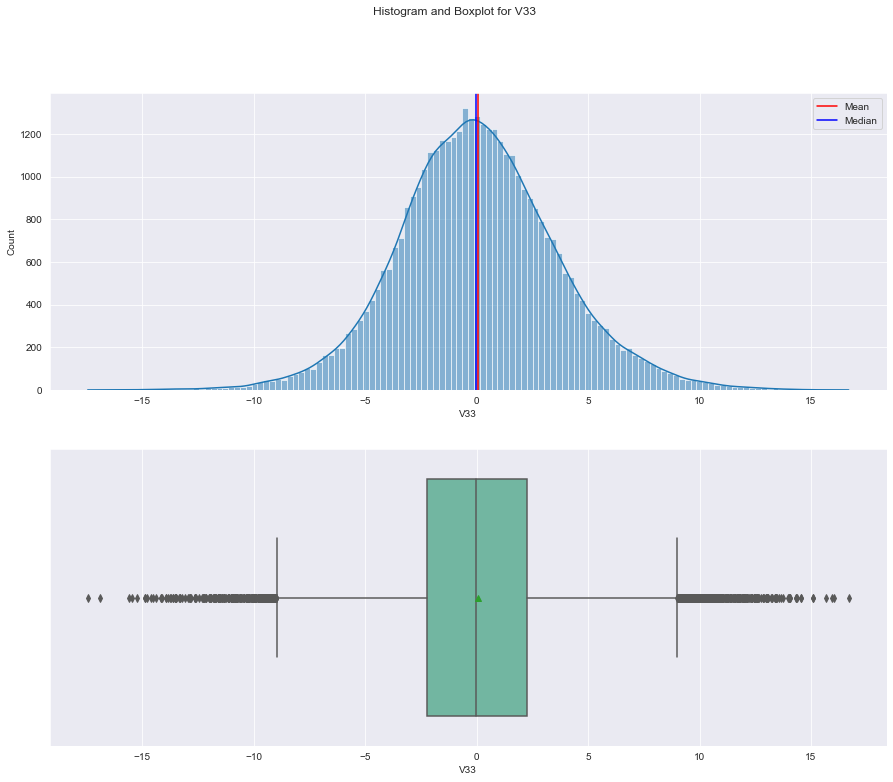

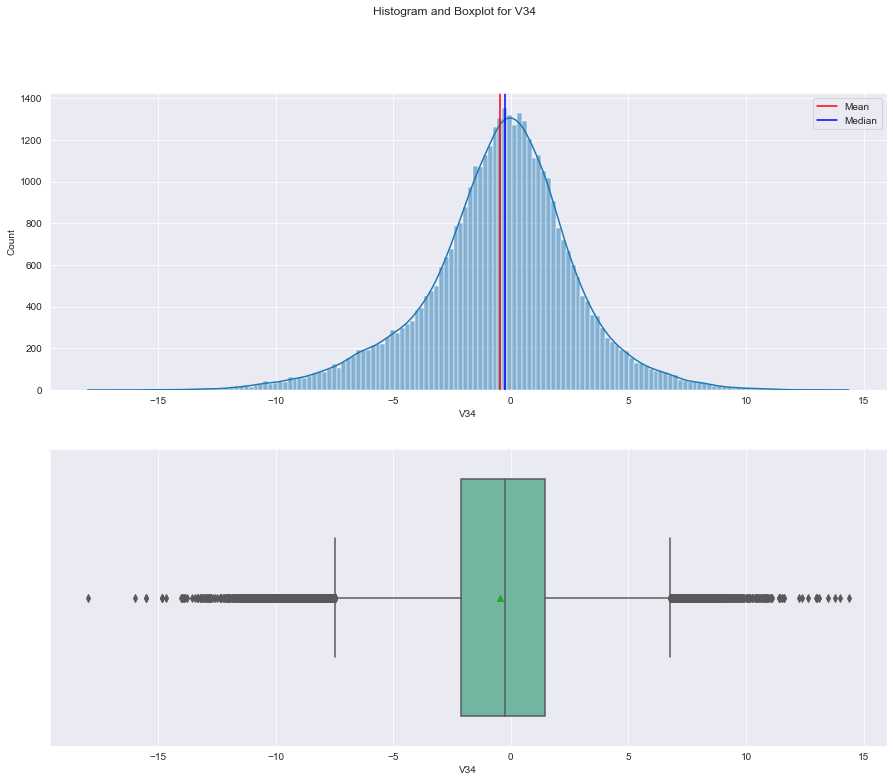

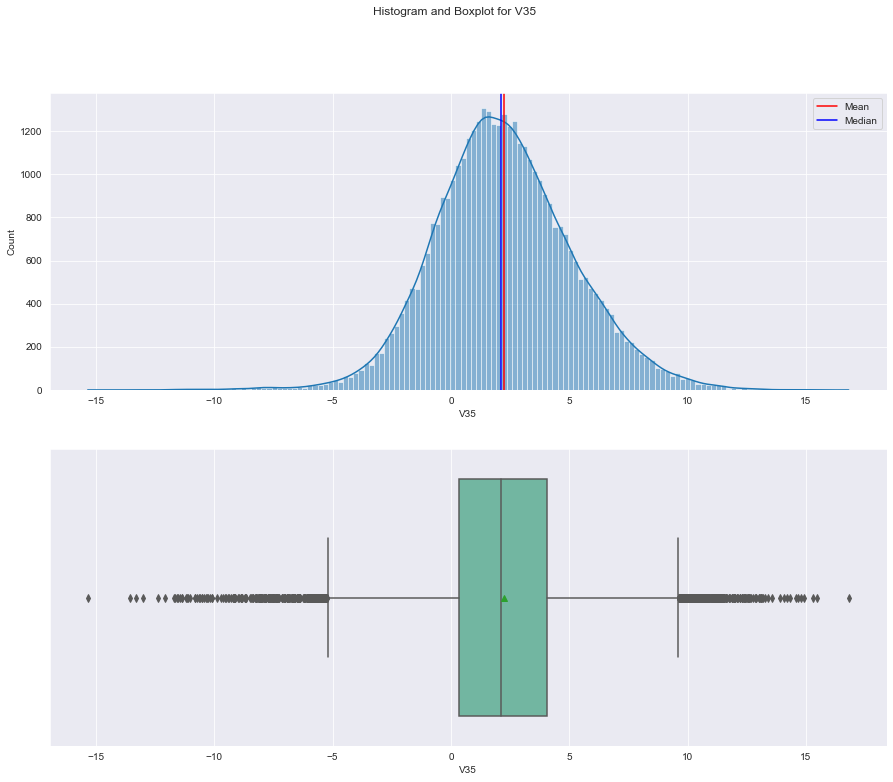

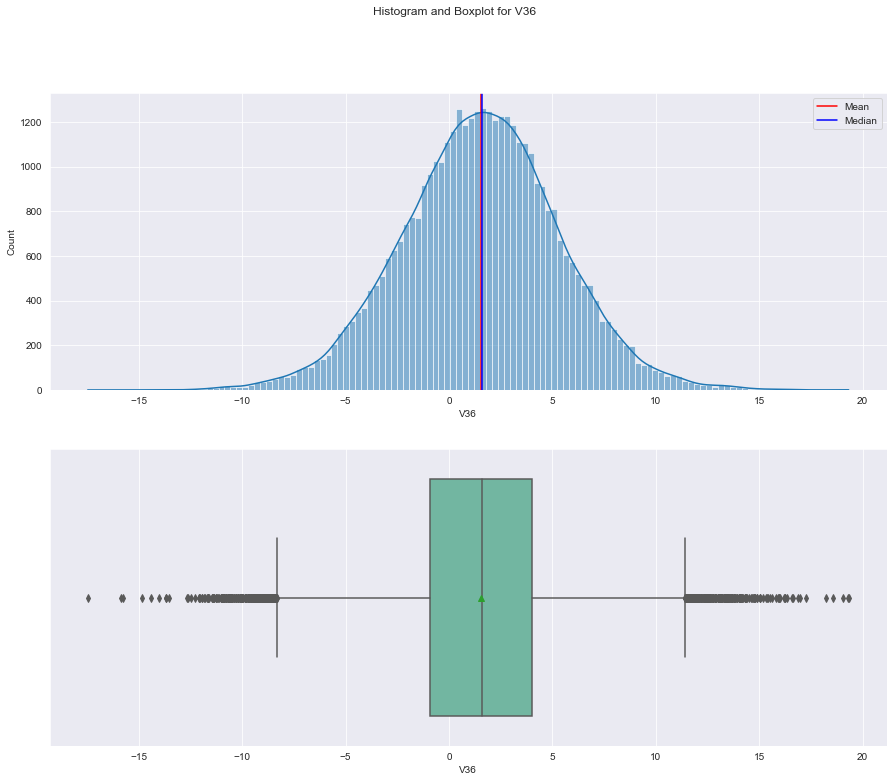

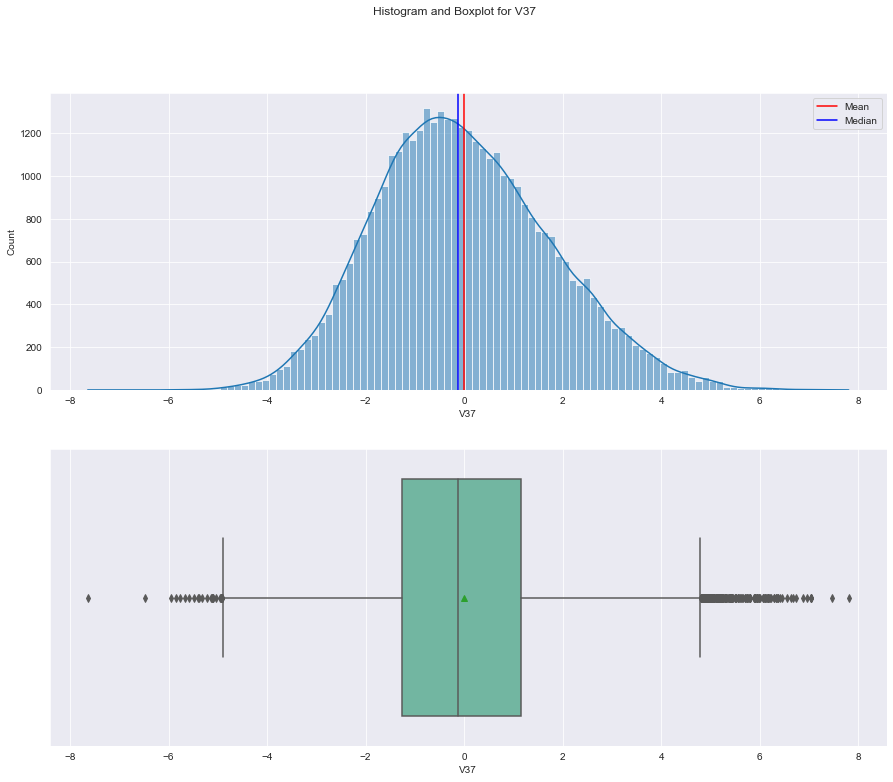

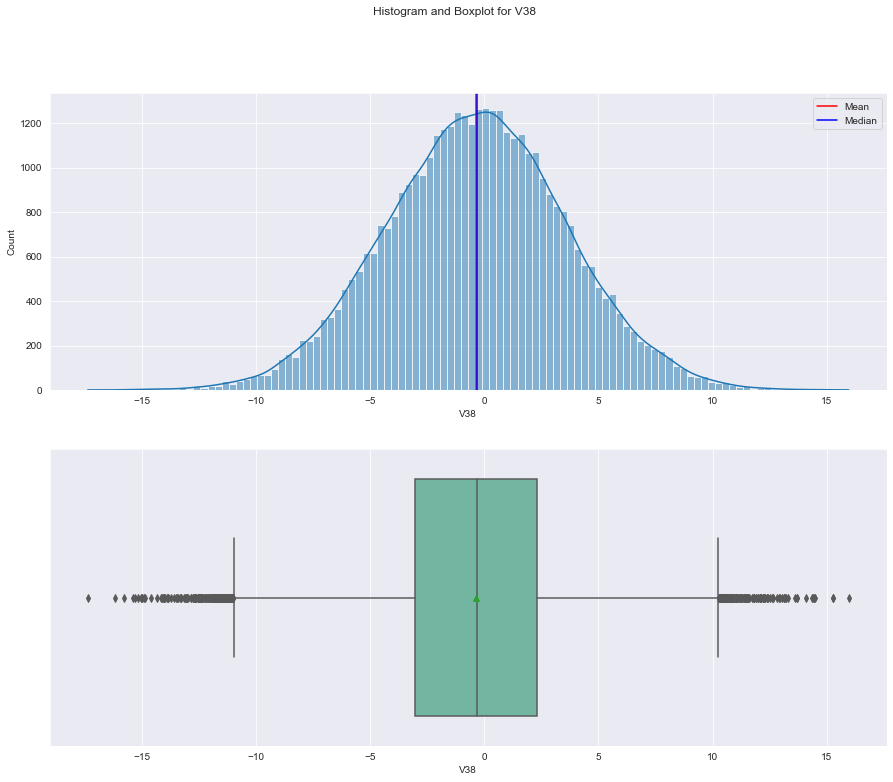

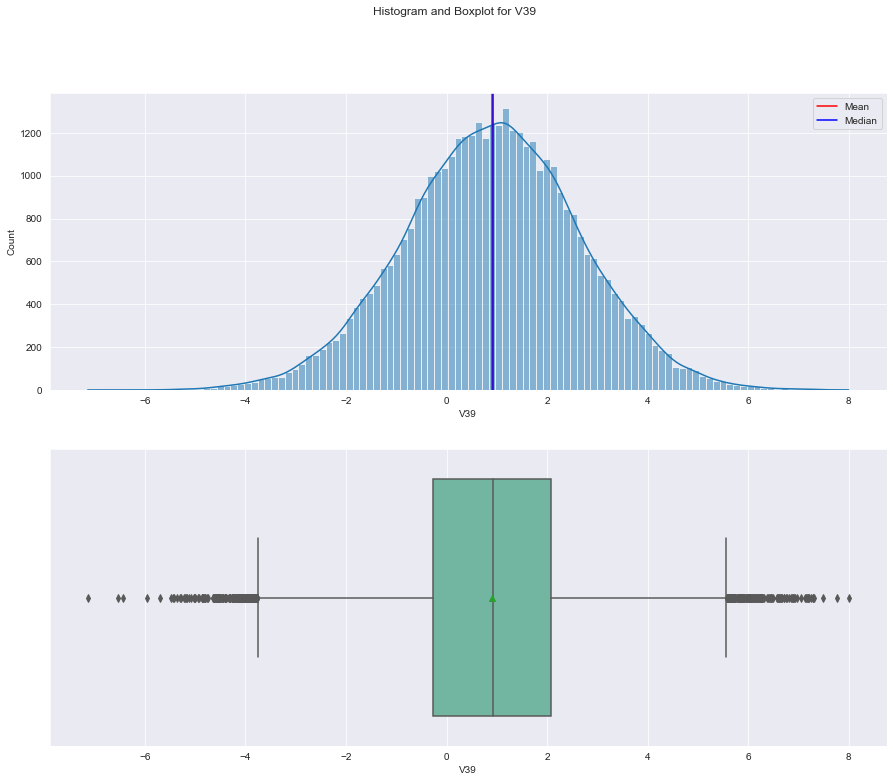

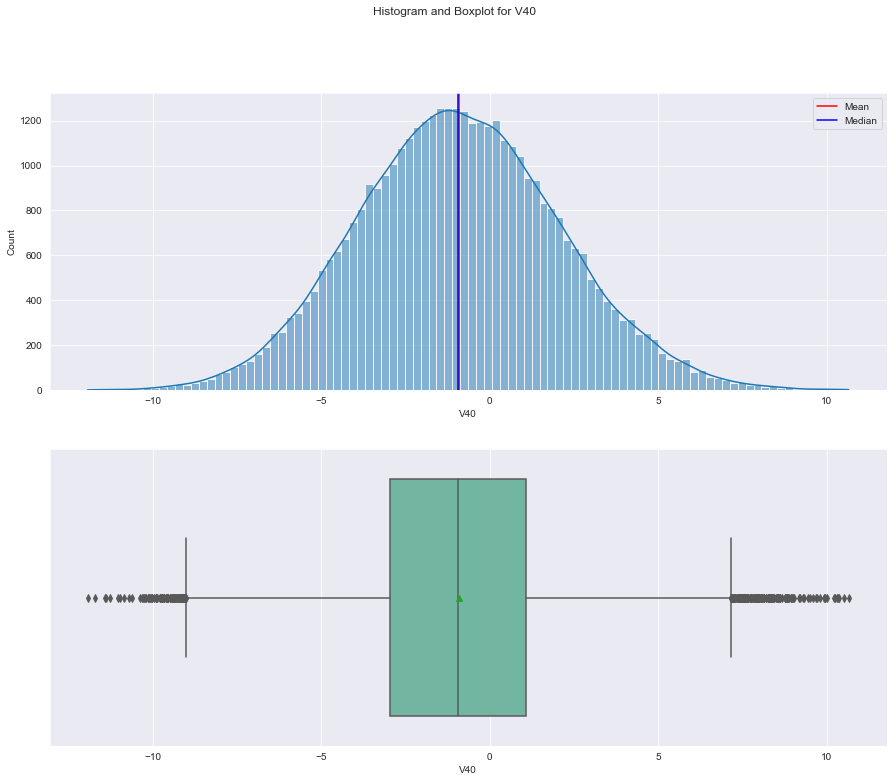

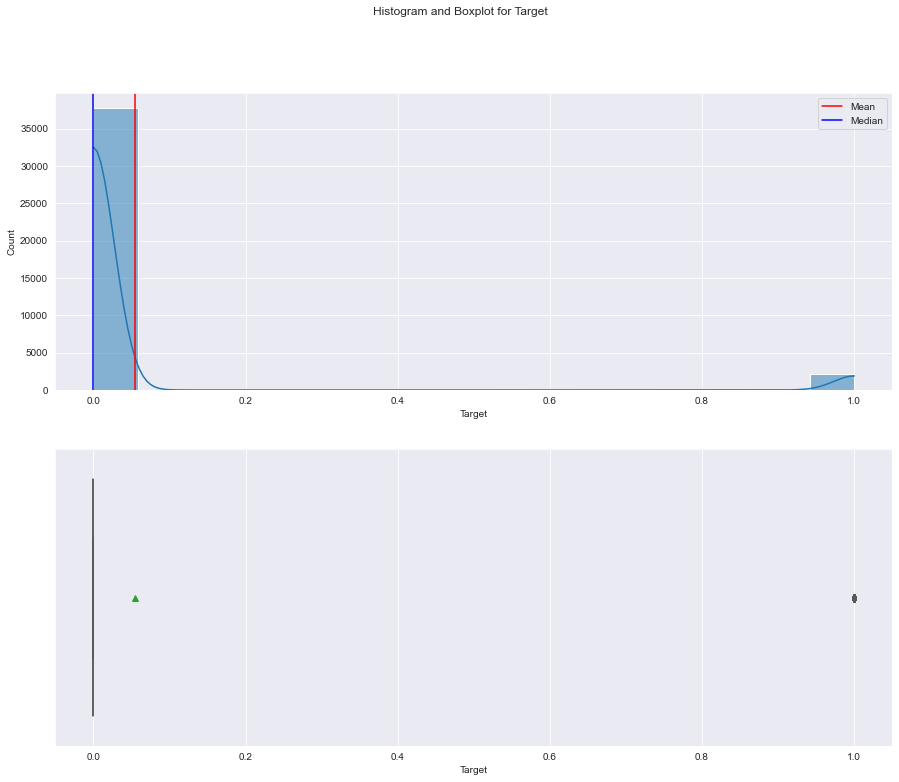

<IPython.core.display.Javascript object>

In [16]:
# plotting all columns data
for i in train.columns:
    Hist_Bar_Plt(train[i],i)

In [17]:
train.skew(axis = 0, skipna = True)

V1        0.547
V2       -0.028
V3        0.329
V4        0.103
V5        0.120
V6       -0.006
V7        0.186
V8       -0.267
V9        0.108
V10      -0.245
V11       0.050
V12       0.095
V13      -0.190
V14       0.005
V15      -0.048
V16      -0.217
V17      -0.148
V18       0.327
V19      -0.141
V20      -0.026
V21      -0.019
V22      -0.148
V23      -0.119
V24       0.244
V25      -0.081
V26      -0.078
V27       0.310
V28       0.056
V29       0.360
V30      -0.360
V31       0.015
V32       0.251
V33       0.130
V34      -0.353
V35       0.087
V36      -0.015
V37       0.308
V38      -0.016
V39      -0.040
V40       0.097
Target    3.918
dtype: float64

<IPython.core.display.Javascript object>

### EDA Univariate Analysis Summary 
- All the columns have almost perfect bell curve. 
- Normalized data for al the columns
- There are outliers present for for all the columns
- There are few slightly right skewed and slightly left skewed columns
- The skewness for all columns fall between -0.3 to 0.5

## Data Pre-processing

In [18]:
# Let's prepare data for processing

# Seperate the features and target variable for both the data sets
X_temp = train.drop(columns='Target')
y_temp = train['Target']

X_test = test.drop(columns='Target')
y_test = test['Target']

<IPython.core.display.Javascript object>

In [19]:
# Split the temporary set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp)

print(X_train.shape, X_val.shape, X_test.shape)

(30000, 40) (10000, 40) (10000, 40)


<IPython.core.display.Javascript object>

### Missing Value Treatment
There are missing values for couple of features. We'll use the median to impute missing values.

In [20]:
imputer = SimpleImputer(strategy="median")
impute = imputer.fit(X_train)

X_train = impute.transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

<IPython.core.display.Javascript object>

## Model evaluation criterion

### 3 types of cost are associated with the provided problem
1. Replacement cost - False Negatives - Predicting no failure, while there will be a failure
2. Inspection cost - False Positives - Predicting failure, while there is no failure 
3. Repair cost - True Positives - Predicting failure correctly

### How to reduce the overall cost?
* We need to create a customized metric, that can help to bring down the overall cost.
* The cost associated with any model = TP * 15000 + FP * 5000 + FN * 40000
* And the minimum possible cost will be when, the model will be able to identify all failures, in that case, the cost will be (TP + FN) * 15000
* So, we will try to maximize `Minimum cost/Cost associated with model`

**Let's create two functions to calculate different metrics and confusion matrix, so that we don't have to use the same code repeatedly for each model.**

In [21]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    TP = confusion_matrix(target, model.predict(predictors))[1, 1]
    FP = confusion_matrix(target, model.predict(predictors))[0, 1]
    FN = confusion_matrix(target, model.predict(predictors))[1, 0]
    Cost = TP * 15 + FP * 5 + FN * 40  # maintenance cost by using model
    Min_Cost = (TP + FN) * 15  # minimum possible maintenance cost = number of actual positives
    Percent = Min_Cost / Cost  # ratio of minimum possible maintenance cost and maintenance cost by model

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
            "Minimum_Vs_Model_cost": Percent,
        },
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

In [22]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

<IPython.core.display.Javascript object>

## **Defining scorer to be used for hyperparameter tuning**

- Every prediction of a classification model will be either a TP, FP, FN or TN.
- Till now at most of the places we wanted to reduce False negatives and hence we tried to maximize "Recall".
- To maximize Recall, we used Recall as a **scorer** in hyperparameter tuning.
- Here, we not only want to minimize false negatives but also false positives and we are also given the costs associated with each type of prediction.
- So, overall we want to reduce the maintenance cost which is: `TP*(Repair cost) + FN*(Replacement cost) + FP*(Inspection cost)`
- In simple language, we can say that we are assigning different weightage to the different types of predictions.
- Do we have any such metric which can help us minimize the maintenance cost? i.e., help us reduce FP and FN as per the weightage - We don't have any such inbuilt metric.
- In sklearn, we can define **custom scorers** also as per our need.
- For this classification problem, we need to reduce the maintenance cost, which can be reiterated as:
  - Minimize (maintenance cost)
  - Maximize (1/maintenance cost)
  - Maximize (minimum possible maintenance cost/maintenance cost)
- Eventually, all 3 metrics will do the same work in the backend and the only difference will be in the scale of the values of the metric.

- The metric provided in the next cell is to `maximize(minimum possible maintenance cost/maintenance cost)`
- You can modify the metric as per convenience and use it further to tune the models.

In [23]:
# defining metric to be used for optimization and with cross-validation
def Minimum_Vs_Model_cost(y_train, y_pred):
    """
    We want the model to optimize the maintenance cost and reduce it to the lowest possible value.
    The lowest possible maintenance cost will be achieved when each sample is predicted correctly.

    In such a scenario, the maintenance cost will be the total number of failures times the maintenance cost of replacing one generator,
    which is given by (TP + FN) * 40 (i.e., the actual positives*40).
    For any other scenario,
    the maintenance cost associated with the model will be given by (TP * 15 + FP * 5 + FN * 40).

    We will use the ratio of these two maintenance costs as the cost function for our model.
    The greater the ratio, the lower the associated maintenance cost and the better the model.
    """
    TP = confusion_matrix(y_train, y_pred)[1, 1]
    FP = confusion_matrix(y_train, y_pred)[0, 1]
    FN = confusion_matrix(y_train, y_pred)[1, 0]
    return ((TP + FN) * 15) / (TP * 15 + FP * 5 + FN * 40)


# A value of .80 here, will represent that the minimum maintenance cost is 80% of the maintenance cost associated with the model.
# Since minimum maintenance cost is constant for any data, when minimum cost will become 100% of maintenance cost associated with the model
# Model will have give the least possible maintenance cost.


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(Minimum_Vs_Model_cost, greater_is_better=True)

# Higher the values, the lower the maintenance cost

<IPython.core.display.Javascript object>

## Model Building with Original data

### Models selected for building
1. Decision Tree Classifier
2. Random Forest Classifier
3. Bagging Classifier
4. AdaBoost Classifier
5. Gradient Boost Classifier
6. XGBoost Classifier

In [24]:
# create empty list to store all the models
models = []

# add models into the list
models.append(("Dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Random Forest", RandomForestClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("XGBoost", XGBClassifier(random_state=1, eval_metric="logloss")))


results = []  # create empty list to store all model's CV scores
names = []  # create empty list to store name of the models


# looping through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")

for name, model in models:
    scoring = scorer
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))
    
print("\n" "Training Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    res = model_performance_classification_sklearn(model,X_train,y_train)
    scores = res['Minimum_Vs_Model_cost'][0]*100
    print("{}: {}".format(name, scores))


Cross-Validation Performance:

Dtree: 65.12035300489133
Random Forest: 71.52966747632996
Bagging: 68.86574469253958
Adaboost: 59.88430481901255
GBM: 67.35879816374911
XGBoost: 76.32838037155607

Training Performance:

Dtree: 100.0
Random Forest: 100.0
Bagging: 91.43281917859134
Adaboost: 61.3160518444666
GBM: 72.94292068198665
XGBoost: 100.0


<IPython.core.display.Javascript object>

## Model Building with Oversampled data


In [25]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

<IPython.core.display.Javascript object>

In [26]:
# create empty list to store all the models
os_models = []

# add models into the list
os_models.append(("OS Dtree", DecisionTreeClassifier(random_state=1)))
os_models.append(("OS Random Forest", RandomForestClassifier(random_state=1)))
os_models.append(("OS Bagging", BaggingClassifier(random_state=1)))
os_models.append(("OS Adaboost", AdaBoostClassifier(random_state=1)))
os_models.append(("OS GBM", GradientBoostingClassifier(random_state=1)))
os_models.append(("OS XGBoost", XGBClassifier(random_state=1, eval_metric="logloss")))


# results = []  # create empty list to store all model's CV scores
# names = []  # create empty list to store name of the models


# looping through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")

for name, model in os_models:
    scoring = scorer
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))
    
print("\n" "Training Performance:" "\n")

for name, model in os_models:
    model.fit(X_train_over,y_train_over)
    res = model_performance_classification_sklearn(model,X_train_over,y_train_over)
    scores = res['Minimum_Vs_Model_cost'][0]*100
    print("{}: {}".format(name, scores))


Cross-Validation Performance:

OS Dtree: 94.13857336531703
OS Random Forest: 96.92752086101537
OS Bagging: 95.40942899036293
OS Adaboost: 82.87444544309412
OS GBM: 86.76274431000867
OS XGBoost: 97.25247518015713

Training Performance:

OS Dtree: 100.0
OS Random Forest: 100.0
OS Bagging: 99.69884106542297
OS Adaboost: 82.97897241836695
OS GBM: 86.83582028618669
OS XGBoost: 99.7514421047695


<IPython.core.display.Javascript object>

## Model Building with Undersampled data

In [27]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

<IPython.core.display.Javascript object>

In [28]:
# create empty list to store all the models
us_models = []

# add models into the list
us_models.append(("US Dtree", DecisionTreeClassifier(random_state=1)))
us_models.append(("US Random Forest", RandomForestClassifier(random_state=1)))
us_models.append(("US Bagging", BaggingClassifier(random_state=1)))
us_models.append(("US Adaboost", AdaBoostClassifier(random_state=1)))
us_models.append(("US GBM", GradientBoostingClassifier(random_state=1)))
us_models.append(("US XGBoost", XGBClassifier(random_state=1, eval_metric="logloss")))


# results = []  # create empty list to store all model's CV scores
# names = []  # create empty list to store name of the models


# looping through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")

for name, model in us_models:
    scoring = scorer
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_under, y=y_train_under, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))
    
print("\n" "Training Performance:" "\n")

for name, model in us_models:
    model.fit(X_train_under,y_train_under)
    res = model_performance_classification_sklearn(model,X_train_under,y_train_under)
    scores = res['Minimum_Vs_Model_cost'][0]*100
    print("{}: {}".format(name, scores))


Cross-Validation Performance:

US Dtree: 77.45754336793459
US Random Forest: 84.67413072888996
US Bagging: 81.69551921903387
US Adaboost: 80.05315674951575
US GBM: 82.95413227954064
US XGBoost: 84.03896599877898

Training Performance:

US Dtree: 100.0
US Random Forest: 100.0
US Bagging: 96.69811320754717
US Adaboost: 83.05199189736663
US GBM: 87.65366114377339
US XGBoost: 100.0


<IPython.core.display.Javascript object>

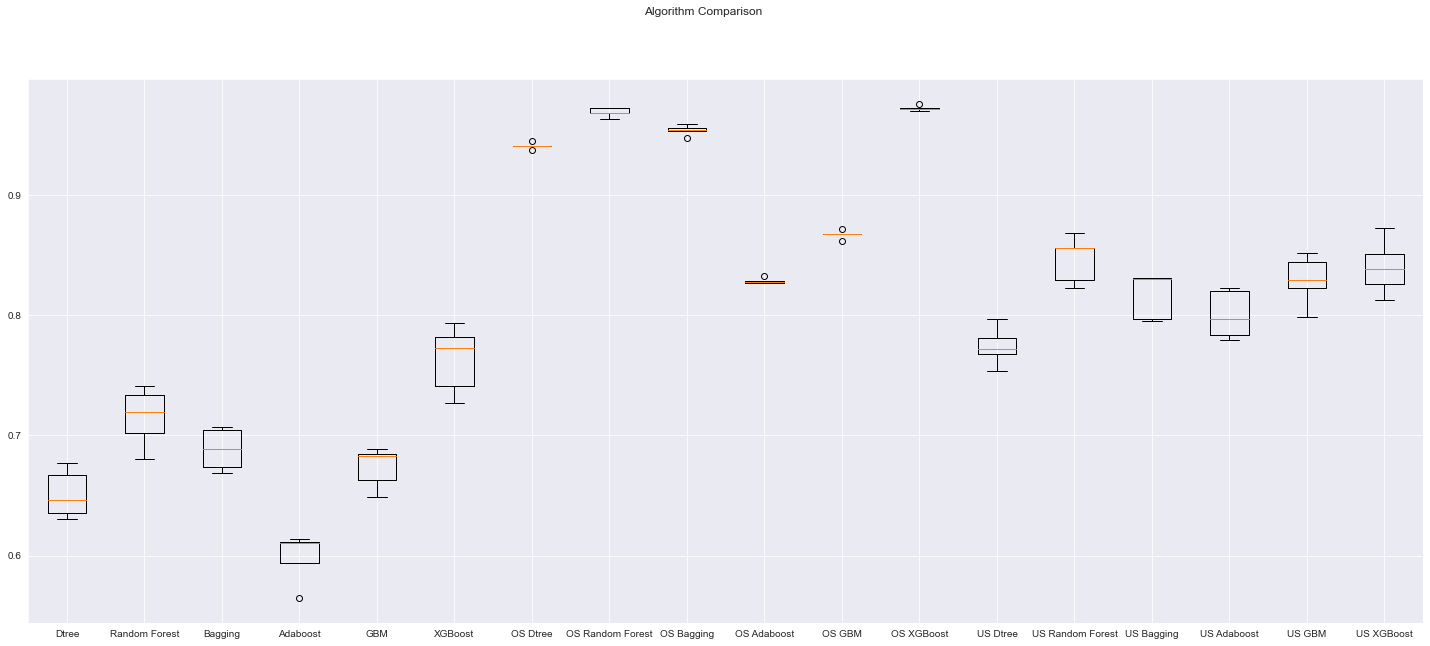

<IPython.core.display.Javascript object>

In [29]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(25, 10))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

## Model Selection

### Observations
- XGBoost has the best cross validation score
- The performance of XGBoost improves with the oversampling and undersampling
- Random Forest is the next best performer
- Random Forest performance for oversampled and undersampled data is consistently high as compared to other models
- Bagging Classifer's almost equal to the performance of Random Forest for all the data
- Adaboost is the lowest performing model
- Models Selected for Hyperparameter Tuning
    - XGBoost
    - Random Forest
    - Bagging Classifier

## HyperparameterTuning 

- **Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

#### For XGBoost:
param_grid={'n_estimators':np.arange(150,300,50),'scale_pos_weight':[5,10],
            'learning_rate':[0.1,0.2], 'gamma':[0,3,5],
            'subsample':[0.8,0.9]}

#### For Gradient Boosting:
param_grid = {
    "init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
    "n_estimators": np.arange(75,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]}


#### For Adaboost:
param_grid = {
    "n_estimators": np.arange(10, 110, 20),
    "learning_rate": [ 0.2, 0.05, 1],
    "base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1)]}

#### For logistic Regression:
param_grid = {'C': np.arange(0.1,1.1,0.1)}

#### For Bagging Classifier:
param_grid = {
              'max_samples': [0.8,0.9], 
              'max_features': [0.8,0.9],
              'n_estimators' : [40,50]}

#### For Random Forest:
param_grid = {
    "n_estimators": [150,250],
    "min_samples_leaf": np.arange(1, 3),
    "max_features": ['sqrt','log2'],
    "max_samples": np.arange(0.2, 0.6, 0.1)}

#### For Decision Trees:
param_grid = {'max_depth': np.arange(2,20), 
              'min_samples_leaf': [1, 2, 5, 7],
              'max_leaf_nodes' : [5, 10,15],
              'min_impurity_decrease': [0.0001,0.001]
             }

## XGBoost
### RandomSearchCV

In [30]:
%%time

# defining model
model = XGBClassifier(random_state=1,eval_metric='logloss')

# Parameter grid to pass in RandomizedSearchCV
param_grid={'n_estimators':np.arange(150,300,50),
            'scale_pos_weight':[5,10,15],
            'learning_rate':[0.1,0.2,0.05], 
            'gamma':[0,1,3,5],
            'subsample':[0.8,0.9,1],
            'max_depth':np.arange(1,5,1),
            'reg_lambda':[5,10]}

#Calling RandomizedSearchCV
xgb_tuned1 = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=20, scoring=scorer, cv=5, random_state=1, n_jobs = -1)

#Fitting parameters in RandomizedSearchCV
xgb_tuned1.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(xgb_tuned1.best_params_,xgb_tuned1.best_score_))

Best parameters are {'subsample': 1, 'scale_pos_weight': 15, 'reg_lambda': 10, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 1} with CV score=0.8067582454317608:
CPU times: user 1min 18s, sys: 569 ms, total: 1min 19s
Wall time: 7min 32s


<IPython.core.display.Javascript object>

In [31]:
# building model with best parameters
xgb_tuned1 = XGBClassifier(
    random_state=1,
    n_estimators=200,
    scale_pos_weight=15,
    gamma=1,
    subsample=1,
    learning_rate=0.2,
    eval_metric="logloss",
    max_depth=4,
    reg_lambda=10,
)
# Fit the model on training data
xgb_tuned1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=10,
              scale_pos_weight=15, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

In [32]:
# Calculating different metrics on train set
xgboost_random_train = model_performance_classification_sklearn(
    xgb_tuned1, X_train, y_train
)
print("Training performance:")
xgboost_random_train

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.998,1.000,0.964,0.982,0.988


<IPython.core.display.Javascript object>

In [33]:
# Calculating different metrics on validation set
xgboost_random_val = model_performance_classification_sklearn(xgb_tuned1, X_val, y_val)
print("Validation performance:")
xgboost_random_val

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.991,0.878,0.945,0.910,0.819


<IPython.core.display.Javascript object>

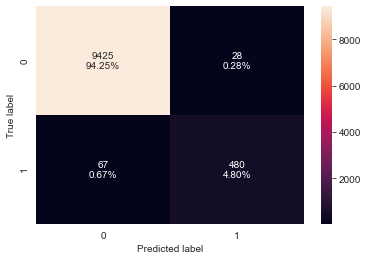

<IPython.core.display.Javascript object>

In [34]:
# creating confusion matrix
confusion_matrix_sklearn(xgb_tuned1, X_val, y_val)

## Random Forest
### RandomSearchCV

In [35]:
%%time

# defining model
model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomizedSearchCV
param_grid = {
    "n_estimators": [150,250],
    "min_samples_leaf": np.arange(1, 3),
    "max_features": ['sqrt','log2'],
    "max_samples": np.arange(0.2, 0.6, 0.1)}

#Calling RandomizedSearchCV
rf_tuned1 = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=20, scoring=scorer, cv=5, random_state=1, n_jobs = -1)

#Fitting parameters in RandomizedSearchCV
rf_tuned1.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(rf_tuned1.best_params_,rf_tuned1.best_score_))

Best parameters are {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.5000000000000001, 'max_features': 'sqrt'} with CV score=0.6991462816364781:
CPU times: user 47.1 s, sys: 300 ms, total: 47.4 s
Wall time: 6min 38s


<IPython.core.display.Javascript object>

In [36]:
# building model with best parameters
rf_tuned1 = RandomForestClassifier(
    n_estimators=250, 
    min_samples_leaf= 1, 
    max_samples=0.5000000000000001, 
    max_features='sqrt',
)
# Fit the model on training data
rf_tuned1.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', max_samples=0.5000000000000001,
                       n_estimators=250)

<IPython.core.display.Javascript object>

In [37]:
# Calculating different metrics on train set
rf_random_train = model_performance_classification_sklearn(
    rf_tuned1, X_train, y_train
)
print("Training performance:")
rf_random_train

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.993,0.882,0.998,0.937,0.836


<IPython.core.display.Javascript object>

In [38]:
# Calculating different metrics on validation set
rf_random_val = model_performance_classification_sklearn(rf_tuned1, X_val, y_val)
print("Validation performance:")
rf_random_val

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.986,0.748,0.990,0.852,0.703


<IPython.core.display.Javascript object>

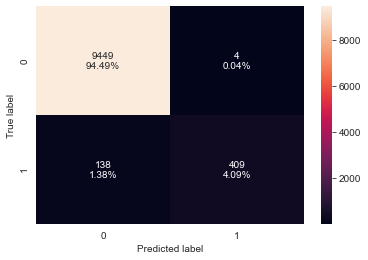

<IPython.core.display.Javascript object>

In [39]:
# creating confusion matrix
confusion_matrix_sklearn(rf_tuned1, X_val, y_val)

## Bagging Classifier
### RandomSearchCV

In [40]:
%%time

# defining model
model = BaggingClassifier(random_state=1)

# Parameter grid to pass in RandomizedSearchCV
param_grid = {
              'max_samples': [0.8,0.9], 
              'max_features': [0.8,0.9],
              'n_estimators' : [40,50]}

#Calling RandomizedSearchCV
bg_tuned1 = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=20, scoring=scorer, cv=5, random_state=1, n_jobs = -1)

#Fitting parameters in RandomizedSearchCV
bg_tuned1.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(bg_tuned1.best_params_,bg_tuned1.best_score_))

Best parameters are {'n_estimators': 50, 'max_samples': 0.9, 'max_features': 0.8} with CV score=0.7097047329751216:
CPU times: user 1min 31s, sys: 435 ms, total: 1min 32s
Wall time: 9min 52s


<IPython.core.display.Javascript object>

In [41]:
# building model with best parameters
bg_tuned1 = RandomForestClassifier(
    n_estimators=50, 
    max_samples=0.9, 
    max_features=0.8
)
# Fit the model on training data
bg_tuned1.fit(X_train, y_train)

RandomForestClassifier(max_features=0.8, max_samples=0.9, n_estimators=50)

<IPython.core.display.Javascript object>

In [42]:
# Calculating different metrics on train set
bg_random_train = model_performance_classification_sklearn(
    bg_tuned1, X_train, y_train
)
print("Training performance:")
bg_random_train

Training performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.999,0.985,1.000,0.993,0.976


<IPython.core.display.Javascript object>

In [43]:
# Calculating different metrics on validation set
bg_random_val = model_performance_classification_sklearn(bg_tuned1, X_val, y_val)
print("Validation performance:")
bg_random_val

Validation performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,0.985,0.757,0.967,0.849,0.707


<IPython.core.display.Javascript object>

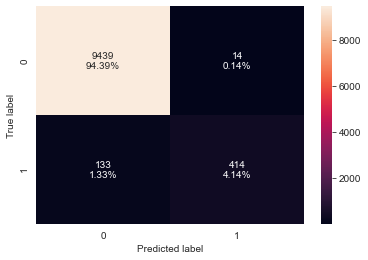

<IPython.core.display.Javascript object>

In [44]:
# creating confusion matrix
confusion_matrix_sklearn(bg_tuned1, X_val, y_val)

## Model Performance comparison and choosing the final model

In [47]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        xgboost_random_train.T,
        rf_random_train.T,
        bg_random_train.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "XGBoost Tuned with Random search",
    "Random Forest Tuned with Random search",
    "Bagging Classifier Tuned with Random search",
]
print("Training performance comparison:")
models_train_comp_df*100

Training performance comparison:


,XGBoost Tuned with Random search,Random Forest Tuned with Random search,Bagging Classifier Tuned with Random search
Accuracy,99.797,99.347,99.920
Recall,100.000,88.232,98.537
Precision,96.414,99.793,100.000
F1,98.174,93.657,99.263
Minimum_Vs_Model_cost,98.775,83.560,97.619


<IPython.core.display.Javascript object>

In [48]:
# Validation performance comparison

models_val_comp_df = pd.concat(
    [
        xgboost_random_val.T,
        rf_random_val.T,
        bg_random_val.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "XGBoost Tuned with Random search",
    "Random Forest Tuned with Random search",
    "Bagging Classifier Tuned with Random search",
]
print("Validation performance comparison:")
models_val_comp_df*100

Validation performance comparison:


,XGBoost Tuned with Random search,Random Forest Tuned with Random search,Bagging Classifier Tuned with Random search
Accuracy,99.050,98.580,98.530
Recall,87.751,74.771,75.686
Precision,94.488,99.031,96.729
F1,90.995,85.208,84.923
Minimum_Vs_Model_cost,81.886,70.278,70.733


<IPython.core.display.Javascript object>

- XGBoost is giving overall good performance on training and validation data
- Overall the metric scores are high on the XGBoost model
- The accuracy, precision and F1 scores are high on the Random Forest, however the model costs are lower
- Bagging Classifier has similar costs 

## Test set final performance

In [49]:
# Calculating different metrics on the test set
xgboost_grid_test = model_performance_classification_sklearn(xgb_tuned1, X_test, y_test)
print("Test performance:")
xgboost_grid_test*100

Test performance:


,Accuracy,Recall,Precision,F1,Minimum_Vs_Model_cost
0,98.870,86.472,92.383,89.330,80.049


<IPython.core.display.Javascript object>

## Pipelines to build the final model


In [50]:
# creating a transformer for numerical variables, which will apply simple imputer on the numerical variables
pipeline = Pipeline(steps=
                [(
                        "imputer", 
                        SimpleImputer(strategy="median")),
                     (
                        "XGB",
                        XGBClassifier(
                            random_state=1,
                            n_estimators=250,
                            scale_pos_weight=10,
                            gamma=0,
                            subsample=0.8,
                            learning_rate=0.2,
                            eval_metric="logloss",
                            reg_lambda=10,
                            max_depth=1,
                        ),
                    ),
                ])

<IPython.core.display.Javascript object>

In [51]:
# get the train data, as the model is already ready we don't need validation set
X_train_new = train.drop(columns='Target')
y_train_new = train['Target']

<IPython.core.display.Javascript object>

In [52]:
# Fit the model on training data
pipeline.fit(X_train_new, y_train_new)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=1,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=250,
                               n_jobs=8, num_parallel_tree=1, random_state=1,
                               reg_alpha=0, reg_lambda=10, scale_pos_weight=10,
                               subsample=0.8, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

<IPython.core.display.Javascript object>

# Business Insights and Conclusions

- The XGBoost model gives 80% minimum model cost
- The accuracy, recall, precision and f1 scores for the selected model are good
- Oversampling and Undersampling techniques are improving the model performance
- Random Forest and Bagging Classifiers overall performed well
- As the features were masked, outlier treatment was not performed
- Outlier treatment and feature enhancement can help performance of the model
